<p align='center'><img src='https://www.sainsburywellcome.org/web/sites/default/files/styles/hero_image/public/2018-07/swc_waves.jpg?itok=UmgSe0bb'
alt="2 Layer Network" height=175px width=auto/></p>

# **Analytical Connectionism 2023**, Gatsby Computational Neuroscience Unit, UCL

# *Tutorial:  Graph-Theoretic Analysis of Parallel Processing in Neural Network Architectures*
Sebastian Musslick

## Outline

This notebook is composed of three sections, each introducing different concepts underlying parallel processing capabilites of neural network architectures.

1.   In the **first section** we will build a **connectionist model of cognitive control** (Cohen, Dunbar & McClelland, 1990), and will wire it to perform the Stroop task. We will then investigate the model's ability to reproduce the response interference effect when performing  **single tasks**. The purpose of this exercise is to familiarize yourself with the network architecture used to study control-dependent processing, and with the notion of single-task interference.

2.   In the **second section** we will build a multi-layer neural network (Musslick et al., 2016) and train it to perform multiple tasks simultaneously. We will then examine the role of shared representations in determining the parallel processing capabilities of the neural network.

3.   In the **third section**, we will introduce graph-theoretic analyses of multitasking capability (Petri et al., 2021). We will examine the effect of representation sharing and network depth in graphs, and eventually use these analyses to predict the parallel processing capability of the network introduced in Section 2.

Note: If you would like to catch up on the basics of neural networks, including the backpropagation algorithm, you may want to check out <a href="https://colab.research.google.com/drive/1z9qobf-pr38xe5e6D5XJ3E_zJ_djLqK0?usp=sharing">this Addendum</a>.

## Before we start: Let's import some packages.

To execute the code block below, click on the little arrow symbol on the left side of the code block:

In [ ]:
import numpy as np # for doing math easily in python
import matplotlib.pyplot as plt # for plotting in python
import seaborn as sns # for beautiful plots in python
import torch.utils.data # for handing neural network training data
import torch.nn as nn # for efficient neural network training

This might take a minute or two. The arrow should turn into a [1] once the code executed successfully and the packages are loaded. Let's now dive into our first neural network simulation!

## Section 1: A Neural Network Model of Controlled Processing

In this section, we get to know a neural network model of cognitive control, called the **Stroop model** (Cohen, Dunbar, & McClelland, 1990). We will use this model to examine single-task interference, and the role of cognitive control in mitigating this interference.

### Performance in the Stroop Task as a Measure of Mental Effort

Cognitive control can be defined as our ability to override habitual responses in order to align behavior with current task goals. For instance, you may be familiar with the so-called Stroop task in which participants have to name the color of a color word, e.g., say "green" in response to:

<font color="green" size=13> **RED** </font>

We call this stimulus "incongruent" because the color and the word are associated with different responses. A congruent stimulus looks like this:

<font color="green" size=13> **GREEN** </font>

Finally, there may be so-called neutral stimuli in which the participant has to respond to the color of a non-word:

<font color="green" size=13> **XXXX** </font>

When studying human performance in the Stroop task, one can measure the error rate as a function of stimulus condition (neutral, incongruent, congruent), and as function of which task the participant performs (color naming or word reading). Human performance matches qualitatively this pattern:

<p align='center'><img src='https://raw.githubusercontent.com/jmasis/nntutorialmentaleffort2021/main/stroop_results.png'
alt="3-layer network with bias units" width=300px height=auto/></p>

That is, cognitive psychologists found that participants make fewer errors when being asked to respond to the word (performing the *word reading task*) compared to responding to the color (performing the *color naming task*). This effect reflects **interference** that our processing mechanisms for word-reading introduce when performing the color naming task. When performing the color-naming task, it is assumed that cognitive control serves to **mitigate this interference**, by strengthening representations for colors. Conversely, because word-reading can be performed without much trouble, it assumed that our processing mechanisms for color naming don't interfere much with the processing mechanisms required for word reading. Thus, researchers assumed that word reading requires less cognitive control than color naming. In addition, participants make fewer errors when color naming to congruent relative to incongruent stimuli, irrespective of the task. Analogously, researchers hypothesized that congruent stimuli require less cognitive control than incongruent stimuli.

### The Stroop Model

To explain these effects, Cohen et al. (1990) came up with a neural network model that operationalizes cognitive control. The model looks like this (adapted from Figure 1 of Cohen et al, 1990):

<p align='center'><img src='https://raw.githubusercontent.com/jmasis/nntutorialmentaleffort2021/main/stroop_neural_network_simple.png'
alt="3-layer network with bias units" width=500px height=auto/></p>


The network consists of three input layers, two hidden layers and one output layer. The input layer on the left encodes the ink color of the stimulus. For instance, if the stimulus was shown in green red, we may set the input vector for the INK COLOR layer to $\begin{bmatrix} 1 & 0 \end{bmatrix}$. The input layer on the right encodes the current word. For instance, if the word would is "GREEN" then we can set the word input layer to $\begin{bmatrix} 0 & 1 \end{bmatrix}$. Finally, the input layer in the middle encodes the task to be performed on the two stimuli. For instance, if the participant would be asked to perform the color naming task, one would set the input units of the task demand layer to $\begin{bmatrix} 1 & 0 \end{bmatrix}$.

The input layers project to two hidden layers, one that represents colors and another one that represents words. E.g., the first unit in the color hidden layer represents the color green. Note that inhibitory connections (negative weights) are depicted as dashed arrows. Finally, both hidden layers project to respective response units in the output layer.

Note that the output layer receives inputs from two sources, the color hidden layer and the word hidden layer. Thus, if the information represented in the color and word hidden layers is incongruent, then the output layer will receive conflicting responses. However, an important feature of the Stroop model is that the hidden and output units are inhibited at rest. That is, these units receive a negative weight from a bias unit. Thus, a more accurate depiction of the network would be:

<p align='center'><img src='https://raw.githubusercontent.com/jmasis/nntutorialmentaleffort2021/main/stroop_neural_network.png'
alt="3-layer network with bias units" width=500px height=auto/></p>

where the green units are bias units. The inhibition is so strong that, without any input from the *TASK DEMAND* layer, the information from the color and word input layers would not "make it through" the hidden layers to the output layer. This is because adding a negative bias pushes the non-linear activation function to the right (see section "The Role of Bias Units" above).

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/326079df67a7bfe602d30d6aee246b64f53b0f39/BiasEffect.png?raw=True'
alt="Effect of bias on sigmoidal activation function" width=400px height=auto/></p>

As a consequence, small net inputs will evaluate to something close to zero. However, the cool part about the Stroop model is that the *TASK DEMAND* layer can provide additional net input to the hidden units, making it possible to disinhibit them. For instance, if we set the color naming unit to 1, then we can provide additonal net input to the color hidden units. This negates the negative bias, allowing information from the *INK COLOR* input layer to flow through to the *RESPONSE* layer. Conversely, if we leave the word reading unit in the *TASK DEMAND* layer at 0, then the information from the *WORD* layer cannot leak through. The output layer would then only receive input from the color hidden units, thus enabling the network to perform the color naming task. This provides a mechanism for cognitive control: allocating control to a task means to activate a task demand unit (i.e., set it to 1).

Now lets look into an actual implementation of the Stroop model...



The following function "**runStroopNetwork**" implements the Stroop model. Note that the weights are denoted as "W_```source_layer```_```target_layer```". However, the weights are not yet defined—this is OK! Defining the weights will be part of an exercise that we will come to later. For now, let's just execute the function below and have a closer look...

In [ ]:
# this function accepts a single input pattern for the color, word and task input layers
# and produces a response at the output layer.
def runStroopNetwork(color_input, word_input, task_input):

    # compute activation of color hidden layer
    net_hidden_color = np.dot(color_input, W_input_color_hidden_color) + \
                       np.dot(task_input, W_input_task_hidden_color) + \
                       bias

    act_hidden_color = 1 / (1 + np.exp(-net_hidden_color))

    # compute activation of word hidden layer
    net_hidden_word = np.dot(word_input, W_input_word_hidden_word) + \
                      np.dot(task_input, W_input_task_hidden_word) + \
                      bias

    act_hidden_word = 1 / (1 + np.exp(-net_hidden_word))

    # compute activation of output layer
    net_output = np.dot(act_hidden_color, W_hidden_color_output) + \
                 np.dot(act_hidden_word, W_hidden_word_output)

    act_output = 1 / (1 + np.exp(-net_output))

    # We apply the softmax function convert the output activation for each unit (response) into a probability
    response_probability = np.exp(net_output) / np.sum(np.exp(net_output), axis=1)

    return response_probability

The network has the following features:


1.   It has two output units
2.   It has 3 input layers and 2 hidden layers.
3.   It uses a softmax function at the output layer.

The first two points aren't really special, since they are simple extensions of simple multi-layer networks; So let's have a look at the computation of the output layer...

The response probabilities of the network are computed as follows:

\begin{align}
P(\text{red}) &= \frac{e^{net_{\text{output},red}}}{e^{net_{\text{output},red}} + e^{net_{\text{output},green}}} \\
P(\text{green}) = 1 - P(\text{red}) &= \frac{e^{net_{\text{output},green}}}{e^{net_{\text{output},red}} + e^{net_{\text{output},green}}}
\end{align}

This function is called the **softmax** function. All it does is that it forces the activities for both output units to sum up to 1. Thus, we can treat them as probabilities. The response probability for each unit is proportional to its respective net input, weighted by the net input of the other unit.

OK, now that we have a Stroop model, we need an experiment environment. The following function "**runStroopExperiment**" probes the network's response for different Stroop conditions (see the code below). For now, let's just execute the function so we can call it later...





In [ ]:
# computes the network's error rate across different conditions

def runStroopExperiment():
    # color naming, congruent stimulus
    color_input = np.array([[1, 0]])    # color: red
    word_input = np.array([[1, 0]])     # word: red
    task_input = np.array([[1, 0]])     # task: color naming
    cn_congruent = runStroopNetwork(color_input, word_input, task_input)

    # color naming, incongruent stimulus
    color_input = np.array([[1, 0]])    # color: red
    word_input = np.array([[0, 1]])     # word: green
    task_input = np.array([[1, 0]])     # task: color naming
    cn_incongruent = runStroopNetwork(color_input, word_input, task_input)

    # color naming, neutral stimulus
    color_input = np.array([[1, 0]])    # color: red
    word_input = np.array([[0, 0]])     # word: XXX
    task_input = np.array([[1, 0]])     # task: color naming
    cn_neutral = runStroopNetwork(color_input, word_input, task_input)

    # word reading, congruent stimulus
    color_input = np.array([[1, 0]])    # color: red
    word_input = np.array([[1, 0]])     # word: red
    task_input = np.array([[0, 1]])     # task: word reading
    wr_congruent = runStroopNetwork(color_input, word_input, task_input)

    # word reading, incongruent stimulus
    color_input = np.array([[0, 1]])    # color: green
    word_input = np.array([[1, 0]])     # word: red
    task_input = np.array([[0, 1]])     # task: word reading
    wr_incongruent = runStroopNetwork(color_input, word_input, task_input)

    # word reading, neutral stimulus
    color_input = np.array([[0, 0]])    # color: red
    word_input = np.array([[1, 0]])     # word: red
    task_input = np.array([[0, 1]])     # task: word reading
    wr_neutral = runStroopNetwork(color_input, word_input, task_input)

    # plot error rates for each condition (assuming "red" is the correct response)
    cn_congruent_error_rate = 1 - cn_congruent[0, 0]
    cn_incongruent_error_rate = 1 - cn_incongruent[0, 0]
    cn_neutral_error_rate = 1 - cn_neutral[0, 0]
    wr_congruent_error_rate = 1 - wr_congruent[0, 0]
    wr_incongruent_error_rate = 1 - wr_incongruent[0, 0]
    wr_neutral_error_rate = 1 - wr_neutral[0, 0]

    return (cn_congruent_error_rate, cn_incongruent_error_rate, cn_neutral_error_rate,
            wr_congruent_error_rate, wr_incongruent_error_rate, wr_neutral_error_rate)

### Exercise 1

Now that we have a Stroop model and a Stroop experiment, let's see how it behaves. The following code section defines the weights for the Stroop model and measures its performance. Execute the code block and see what happens.
Does the network produce the expected behavior? Well, of course not, otherwise this wouldn't be an exercise. Now, can you adjust the weights of the Stroop model so that it produces task interference effects similar to the figure shown above?

Open ended exercise: A major tenet of the Stroop model is that the word reading task requires less cognitive control because it's processing path from the input to the output layer is stronger, as a consequence of training (lifelong practice on word reading as opposed to color naming). Wouldn't it be nice if we could show that this behavior results indeed from training? To do so, you may want to think tacke two (optional) extended exercises:


1.   Apply the backpropagation algorithm to make the Stroop network trainable.
2.   Train the Stroop network on a higher proportion of word reading conditions than color naming conditions. Can you replicate the behavioral pattern expected in the Stroop task?

You are, of course, welcome to skip these exercises and proceed to the next part in which we extend the Stroop Model to perform multiple tasks simultaneously.



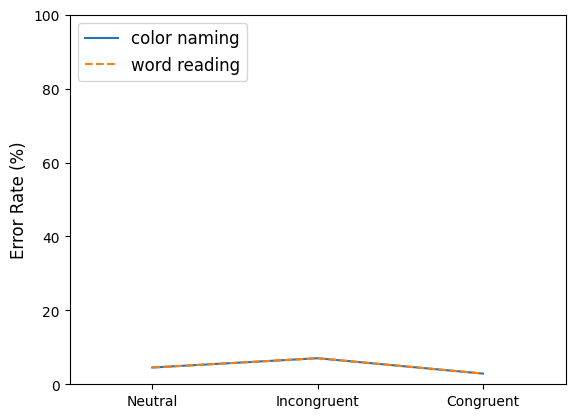

In [ ]:
# STROOP NETWORK WEIGHTS

bias = -4

# weights projecting from color input layer to color hidden layer
W_input_color_hidden_color = 2 * np.array([[1, -1],   # EXPERIMENT WITH THESE WEIGHTS
                                             [-1, 1]])

# weights projecting from color hidden layer to output layer
W_hidden_color_output = 2 * np.array([[1, -1],    # EXPERIMENT WITH THESE WEIGHTS
                                        [-1, 1]])

# weights projecting from word input layer to word hidden layer
W_input_word_hidden_word = 2 * np.array([[1, -1],   # EXPERIMENT WITH THESE WEIGHTS
                                           [-1, 1]])

# weights projecting from word hidden layer to output layer
W_hidden_word_output = 2 * np.array([[1, -1],   # EXPERIMENT WITH THESE WEIGHTS
                                      [-1, 1]])

# weights projecting from task layer to color hidden layer
W_input_task_hidden_color = 4.0 * np.array([[1, 1],   # EXPERIMENT WITH THESE WEIGHTS
                                            [0, 0]])

# weights projecting from task layer to word hidden layer
W_input_task_hidden_word = 4.0 * np.array([[0, 0],    # EXPERIMENT WITH THESE WEIGHTS
                                           [1, 1]])


# PLOT THE NETWORK PERFORMANCE

(cn_congruent_error_rate, cn_incongruent_error_rate, cn_neutral_error_rate,
            wr_congruent_error_rate, wr_incongruent_error_rate, wr_neutral_error_rate) = runStroopExperiment()

x_data = [0, 1, 2]
y_data_col = [cn_neutral_error_rate * 100, cn_incongruent_error_rate * 100, cn_congruent_error_rate * 100]
y_data_wrd = [wr_neutral_error_rate * 100, wr_incongruent_error_rate * 100, wr_congruent_error_rate * 100]
x_limit = [-0.5, 2.5]
y_limit = [0, 100]
x_label = "Condition"
y_label = "Error Rate (%)"
legend = ('color naming', 'word reading')

plt.plot(x_data, y_data_col, label=legend[0])
plt.plot(x_data, y_data_wrd, '--', label=legend[1])
plt.xlim(x_limit)
plt.ylim(y_limit)
plt.ylabel(y_label, fontsize="large")
plt.legend(loc=2, fontsize="large")
plt.xticks([0, 1, 2], ['Neutral', 'Incongruent', 'Congruent'],rotation=0)
plt.show()

#### Solution

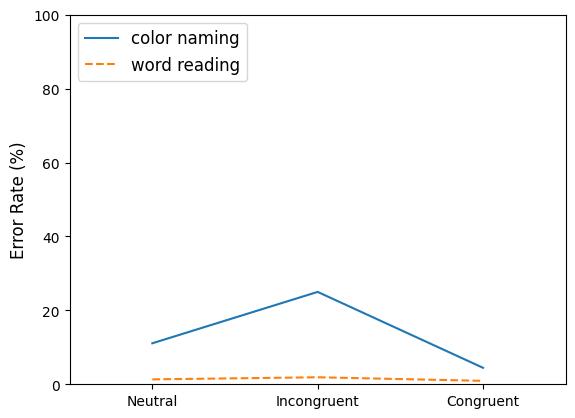

In [ ]:
# STROOP NETWORK WEIGHTS

bias = -4

# weights projecting from color input layer to color hidden layer
W_input_color_hidden_color = 2.2 * np.array([[1, -1],
                                             [-1, 1]])

# weights projecting from color hidden layer to output layer
W_hidden_color_output = 1.3 * np.array([[1, -1],
                                        [-1, 1]])

# weights projecting from word input layer to word hidden layer
W_input_word_hidden_word = 2.6 * np.array([[1, -1],
                                           [-1, 1]])

# weights projecting from word hidden layer to output layer
W_hidden_word_output = 2.5 * np.array([[1, -1],
                                      [-1, 1]])

# weights projecting from task layer to color hidden layer
W_input_task_hidden_color = 4.0 * np.array([[1, 1],
                                            [0, 0]])

# weights projecting from task layer to word hidden layer
W_input_task_hidden_word = 4.0 * np.array([[0, 0],
                                           [1, 1]])


# PLOT THE NETWORK PERFORMANCE

(cn_congruent_error_rate, cn_incongruent_error_rate, cn_neutral_error_rate,
            wr_congruent_error_rate, wr_incongruent_error_rate, wr_neutral_error_rate) = runStroopExperiment()

x_data = [0, 1, 2]
y_data_col = [cn_neutral_error_rate * 100, cn_incongruent_error_rate * 100, cn_congruent_error_rate * 100]
y_data_wrd = [wr_neutral_error_rate * 100, wr_incongruent_error_rate * 100, wr_congruent_error_rate * 100]
x_limit = [-0.5, 2.5]
y_limit = [0, 100]
x_label = "Condition"
y_label = "Error Rate (%)"
legend = ('color naming', 'word reading')

plt.plot(x_data, y_data_col, label=legend[0])
plt.plot(x_data, y_data_wrd, '--', label=legend[1])
plt.xlim(x_limit)
plt.ylim(y_limit)
plt.ylabel(y_label, fontsize="large")
plt.legend(loc=2, fontsize="large")
plt.xticks([0, 1, 2], ['Neutral', 'Incongruent', 'Congruent'],rotation=0)
plt.show()

## Section 2: Parallel Processing Interference as a Function of Representation Sharing

Now that we have gained a basic undersanding of cognitive control, let us extend the Stroop network to a "Multitasking Network". Here, we refer to the term "multitasking" in the psychological sense, that is, the simultaneous *execution* of multiple tasks.

### Extending the Stroop Model to Perform Multiple Tasks

The network used for all further experiments is shown the Figure below.

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/main/FIG_NETWORK.png?raw=true'
alt="Network Architecture and Training Environment" width=500px height=auto/></p>

#### Inputs to the Network

It has two sets of input units: a stimulus set, $x_1$, used to represent stimulus features; and a task set, $x_2$, used to indicate which task(s) should be performed on a given trial. The stimulus set is further divided into $g_1$ groups of units, each of which is used to represent an independent stimulus dimension comprised of $m$ features along each dimension. Accordingly, each group comprises $m$ units, with each feature represented as a one-hot input pattern over the group. The task set comprises a single group with a number of units equal to the number of tasks that can be specified (see below), and one unit is used to represent each task.

In the example of the Stroop task, stimulus dimensions correspond to colors or words. Individual stimulus features correspond to instances of those dimensions, e.g., specific colors like red or blue. Note that, contrast to the Stroop Network introduced above, the network here can represent more than two tasks in the task input layer.

#### Projections

Both sets of input units project to a single set of hidden units, with connection weights $w_1$ and $w_2$ for the stimulus set and task set, respectively.

**Note:** *Unlike in the Stroop Network introduced above, there is no grouping of hidden according to the input dimensions. All input dimensions project to the same set of hidden units, allowing the network to share representations between tasks to varying extends.*

 The $H$ units in the hidden layer use the sigmoidal activation function $f$ introduced in the previous section, producing an activation vector of

\begin{equation*}
    h = f(w_1 x_1 + w_2 x_2 + b_1)
\end{equation*}

where $b_1 = -2$ is a fixed bias, ensuring that the units are inhibited if no input is provided (see previous Section). All of the hidden units, as well as the input units in the task set, project to all units in the output layer, with weights $v_1$ and $v_2$, respectively. The output layer, like the stimulus set of the input layer, is divided into $g_2$ pools of units, each of which is used to represent an independent response dimension comprised of $m$ responses along each dimension. Thus, each pool comprises $m$ units, with each response represented as a one-hot input pattern over the set. Like the hidden layer, the output layer uses a sigmoidal activation function $f$, along with output bias $b_2 = b_1$, leading to a final output of

\begin{equation*}
    y = f(v_1 h + v_2 x_2 + b_2)
\end{equation*}

or, in terms of inputs only,

\begin{equation*}
    y = f(v_1 f(w_1 x_1 + w_2 x_2 + b_1) + v_2 x_2 + b_2)
\end{equation*}

Note that the task input $x_2$ appears twice here, as there are two independent pathways involving $x_2$ (one projecting to the hidden layer and the other to the output layer).

The following code implements our network.

In [ ]:
Ningroup = 4 # Number of input groups (stimulus dimensions)
Noutgroup = 3 # Number of output groups (response dimensions)
Nfeatures = 3 # Number of features / group (stimulus features per group)
Din = (Ningroup*Nfeatures) + (Ningroup * Noutgroup) # Feature inputs + task inputs
Dout = Noutgroup * Nfeatures
H = 200 # Hidden layer size

class MultitaskingNet(nn.Module):
    def __init__(self):
        super(MultitaskingNet, self).__init__()
        self.fc1 = nn.Linear(Din, H)  # input-to-hidden layer
        self.fc2 = nn.Linear(H + Ningroup*Noutgroup, Dout)  # hidden-to-output layer

    def forward(self, input):
        f1 = self.fc1(input)
        f1 = torch.sigmoid(f1)
        f1combo = torch.cat((f1, input[:, (Ningroup*Nfeatures):]), 1)  # For batch learning
        f2 = self.fc2(f1combo)
        f2 = torch.sigmoid(f2)
        return f2, f1  # output activations, hidden activations

The network above implements four stimulus dimensions and three response dimensions (i.e., stimulus pools $g_1 = 4$ and output pools $g_2 = 3$). This allows us to implement a total of 12 tasks ($x_2 = 12$; see section below). Since each stimulus dimension has three features, and each response dimension has three possible responses (i.e., $m = 3$), in total the network has 24 input units ($x_1 = 12$ stimulus input, and $x_2 = 12$ task input units) and 12 output units, as well as $H = 200$ hidden units.

*Note: The number of hidden units is chosen to avoid imposing a representational bottleneck on the network, thus allowing it the opportunity to learn separate representations for the mappings of each of the twelve tasks. This is done to ensure that any tendencies for the network to learn lower-dimensional representation are more likely to reflect factors of interest (viz., initialization and/or training protocols) and cannot be attributed to limited representational resources.*

### Training Enviornment

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/main/FIG_ENV.png?raw=true'
alt="Network Architecture and Training Environment" width=500px height=auto/></p>

**Definition of a Task**: As described above, a task defines a one-to-one mapping from the features along a single stimulus dimension to the responses of a single output dimension, reflecting response mappings in classic multitasking paradigms. This corresponds to the mapping of the $m$ input units from the specified group $g_1$ of the stimulus units $x_1$ to the associated $m$ output unit in the specified group $g_2$ of the output units. In aggregate, this yields $g_1 \cdot g_2$ tasks, and thus the task set $x_2$ has that many units.

**Single-Tasking**: For a given trial, a single feature unit activates in each pool of the stimulus set $x_1$ (i.e., each of the $g_1$ input pools has one of its $m$ units activated). For the performance of a single task, only a single unit activates in the task set $x_2$. The network then must activate the output unit in the response pool corresponding to the input unit activated in the stimulus pool specified by the task unit activated in $x_2$, and suppress activity of all other output units. For example, task 1 consists of mapping the $m$ units of input pool $g_1 = 1$ to the $m$ units of the output pool $g_2 = 1$; as only one one of the $m$ units is active, the task consists of mapping the active $m$th element of $g_1$ to the $m$th element of $g_2$, while outputting null responses elsewhere.

**Multitasking**: For multitasking performance, two or more units in the task set are activated, and the network is required to activate the response corresponding to the input for each task specified, and suppress all other output units.

**Note**: *Multitasking is restricted to only those tasks that share neither an input set nor output set.*

The function below sets up our task environment. There is no need to understand the underlying code of the function (it's a mess but it works). We can focus on more interesting things, such as probing the role of shared representations for multitasking.

In [ ]:
def generate_data(num_samples = 500,
                  single_tasking=True,
                  multi_tasking=False):

  N = num_samples
  Ntest = 0
  # Single12: assumes a 4x3 task setup e.g. 12 tasks, does a 9/3 split
  Single12PartTrain = False
  Single12PartTest = False
  # For base train
  Single12All = single_tasking
  Multi12All = multi_tasking
  # For finetune
  # Single12All = False
  # Multi12All = True

  # Generate training data:
  x = torch.zeros((N + Ntest, Din))
  y = torch.zeros((N + Ntest, Dout))

  from sympy.utilities.iterables import multiset_permutations
  base = np.zeros(Nfeatures)
  base[0] = 1
  xfull = np.zeros((Nfeatures+1, Nfeatures))
  xfull[-1,:] = np.zeros(Nfeatures)
  iter = 0
  for p in multiset_permutations(base):
      xfull[iter,:] = p
      iter+=1

  for i in range(N + Ntest):
      if i == N:  # Can change task generation settings for testing data here
          # Partial Training
          Single12PartTrain = False
          Single12PartTest = False
          # Train
          Single12All = False
          Multi12All = True
          # Finetune
          #Single12All = False
          #Multi12All = True
      indices = np.random.choice(Nfeatures, Ningroup, replace=True)
      xinp = xfull[indices, :].flatten()  # Ningroup sets of random length-3 one hot vectors
      # Now for the hard part: xtask
      if Single12PartTrain:
          xtask = np.random.permutation([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
          # Remove non-train e.g. 2,4,6
          while np.sum(np.where(xtask==1)[0][0] == np.array([2,4,6]))==1:
              xtask = np.random.permutation([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
          taskids = np.zeros((12, 12))
          for j in range(12):
              taskids[j, j] = 1
      if Single12PartTest:
          xtask = np.random.permutation([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
          # Keep only non train e.g. only 2,4,6, e.g. remove 0/1/3/5/7/8/9/10/11
          while np.sum(np.where(xtask==1)[0][0] == np.array([2,4,6]))==0:
              xtask = np.random.permutation([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
          taskids = np.zeros((12, 12))
          for j in range(12):
              taskids[j, j] = 1
      if Single12All:
          xtask = np.random.permutation([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
          taskids = np.zeros((12, 12))
          for j in range(12):
              taskids[j, j] = 1
      if Multi12All: # randomly choose 2 or 3 tasks simultaneously
          randnum = np.random.rand()
          if single_tasking is True:
            p_single_tasking = .33
            p_dual_tasking = .66
          else:
            p_single_tasking = 0
            p_dual_tasking = .5
          if randnum < p_single_tasking:
              xtask = np.random.permutation([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
          elif randnum < p_dual_tasking:
              indices = np.random.choice(3, 2, replace=False)
              indices = np.insert(indices, np.random.randint(0, 3), 3)
              indices = np.insert(indices, np.random.randint(0, 4), 3)
              xtask = xfull[indices,
                      :].flatten()  # 2 sets of random length-3 one hot vectors, non-repeating, with one set of all 0s
          else:
              indices = np.random.choice(3, 3, replace=False)
              indices = np.insert(indices, np.random.randint(0, 4), 3)
              xtask = xfull[indices, :].flatten()  # 3 sets of random length-3 one hot vectors, non-repeating
          # Generate taskids
          taskids = np.zeros((12 + 36 + 24, 12))
          for j in range(12):  # 12 single tasks
              taskids[j, j] = 1
          for j in range(36):  # how many double tasks? 6*6 = 36
              # 6 possibilites for each 1-2-3 set: 12,13,21,23,31,32
              # 6 possibilities for the 00: 00xx, 0x0x, 0xx0, x00x, x0x0, xx00
              if j < 6:
                  taskids[12 + j, 0:6] = np.zeros(6)
                  taskids[12 + j, 6:9] = xfull[j // 2, :]  # 0 0 1 1 2 2
                  taskids[12 + j, 9:12] = xfull[((j // 2) + 1 + (j % 2)) % 3, :]  # 1 2 2 0 0 1
              elif j < 12:
                  taskids[12 + j, 0:3] = np.zeros(3)
                  taskids[12 + j, 6:9] = np.zeros(3)
                  taskids[12 + j, 3:6] = xfull[(j - 6) // 2, :]  # 0 0 1 1 2 2
                  taskids[12 + j, 9:12] = xfull[(((j - 6) // 2) + 1 + (j % 2)) % 3, :]  # 1 2 2 0 0 1
              elif j < 18:
                  taskids[12 + j, 0:3] = np.zeros(3)
                  taskids[12 + j, 9:12] = np.zeros(3)
                  taskids[12 + j, 3:6] = xfull[(j - 12) // 2, :]  # 0 0 1 1 2 2
                  taskids[12 + j, 6:9] = xfull[(((j - 12) // 2) + 1 + (j % 2)) % 3, :]  # 1 2 2 0 0 1
              elif j < 24:
                  taskids[12 + j, 3:9] = np.zeros(6)
                  taskids[12 + j, 0:3] = xfull[(j - 18) // 2, :]  # 0 0 1 1 2 2
                  taskids[12 + j, 9:12] = xfull[(((j - 18) // 2) + 1 + (j % 2)) % 3, :]  # 1 2 2 0 0 1
              elif j < 30:
                  taskids[12 + j, 3:6] = np.zeros(3)
                  taskids[12 + j, 9:12] = np.zeros(3)
                  taskids[12 + j, 0:3] = xfull[(j - 24) // 2, :]  # 0 0 1 1 2 2
                  taskids[12 + j, 6:9] = xfull[(((j - 24) // 2) + 1 + (j % 2)) % 3, :]  # 1 2 2 0 0 1
              else:
                  taskids[12 + j, 6:12] = np.zeros(6)
                  taskids[12 + j, 0:3] = xfull[(j - 30) // 2, :]  # 0 0 1 1 2 2
                  taskids[12 + j, 3:6] = xfull[(((j - 30) // 2) + 1 + (j % 2)) % 3, :]  # 1 2 2 0 0 1
          from sympy.utilities.iterables import multiset_permutations

          # for j in range(16): # Triples: 0,1,2,3
          # 0123, 0132, 0213, 0231, 0312, 0321 * 4 =24
          j = 0
          for q in multiset_permutations([0, 1, 2, 3]):
              taskids[12 + 36 + j, 0:3] = xfull[q[0]]
              taskids[12 + 36 + j, 3:6] = xfull[q[1]]
              taskids[12 + 36 + j, 6:9] = xfull[q[2]]
              taskids[12 + 36 + j, 9:12] = xfull[q[3]]
              j += 1
      # Generate total input
      x[i, :(Ningroup*Nfeatures)] = torch.from_numpy(xinp)
      x[i, (Ningroup*Nfeatures):] = torch.from_numpy(xtask)
      # Generate outputs
      yout = np.zeros(Noutgroup*Nfeatures)
      if Ningroup == 4: # 4/3 setup
          yout[:Nfeatures]            = xtask[0] * xinp[:Nfeatures] + xtask[3] * xinp[Nfeatures:2*Nfeatures] + xtask[6] * xinp[2*Nfeatures:3*Nfeatures] + xtask[9] * xinp[3*Nfeatures:]
          yout[Nfeatures:2*Nfeatures] = xtask[1] * xinp[:Nfeatures] + xtask[4] * xinp[Nfeatures:2*Nfeatures] + xtask[7] * xinp[2*Nfeatures:3*Nfeatures] + xtask[10] * xinp[3*Nfeatures:]
          yout[2*Nfeatures:]          = xtask[2] * xinp[:Nfeatures] + xtask[5] * xinp[Nfeatures:2*Nfeatures] + xtask[8] * xinp[2*Nfeatures:3*Nfeatures] + xtask[11] * xinp[3*Nfeatures:]
      y[i, :] = torch.from_numpy(yout)

  x_train = x[:N, :]
  y_train = y[:N, :]
  x_test = x[-Ntest:, :]
  y_test = y[-Ntest:, :]

  return x_train, y_train



Before we proceed with training the network, let's have a brief look at the data we are generating. In the simulation below, we will train the network to perform single tasks and test it to execute multiple tasks simultaneously.

The code below showcases some of the data for **single tasking**.

Text(0.5, 1.0, 'Example Output')

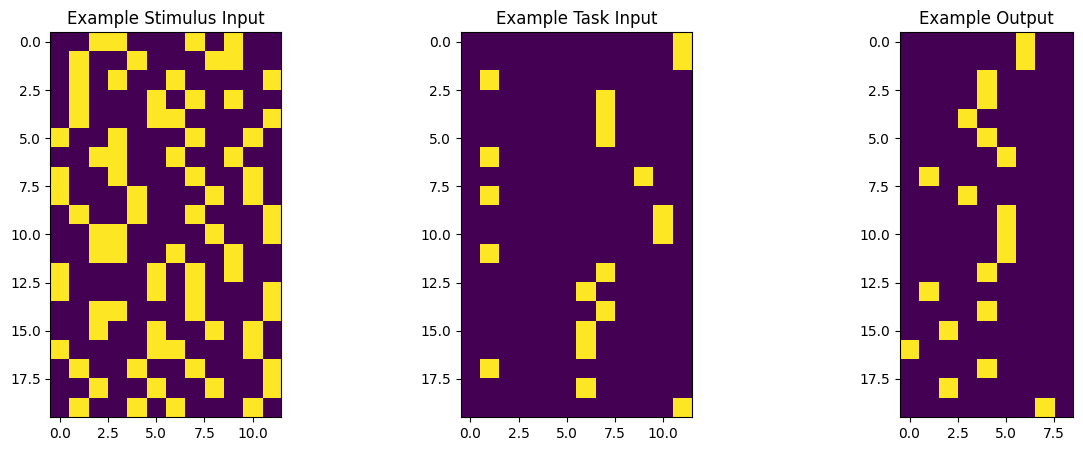

In [ ]:
x_single_tasking, y_single_tasking = generate_data(num_samples=20,
                                             single_tasking = True,
                                             multi_tasking = False)

# extract the input to the stimulus layer
stimulus_input = x_single_tasking[:, :(Ningroup*Nfeatures)]

# extract the input to the task layer
task_input = x_single_tasking[:, (Ningroup*Nfeatures):]

# Create a single figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the first subplot
axes[0].imshow(stimulus_input)
axes[0].set_title("Example Stimulus Input")

# Plot the second image on the second subplot
axes[1].imshow(task_input)
axes[1].set_title("Example Task Input")

# Plot the third image on the third subplot
axes[2].imshow(y_single_tasking)
axes[2].set_title("Example Output")

The code below showcases some of the data for **multitasking**.

Text(0.5, 1.0, 'Example Output')

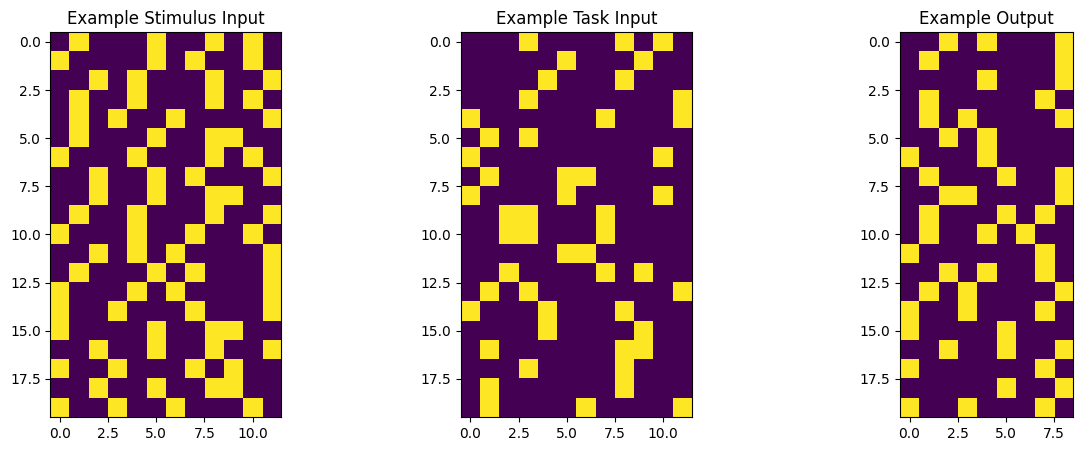

In [ ]:
x_single_tasking, y_single_tasking = generate_data(num_samples=20,
                                             single_tasking = False,
                                             multi_tasking = True)

# extract the input to the stimulus layer
stimulus_input = x_single_tasking[:, :(Ningroup*Nfeatures)]

# extract the input to the task layer
task_input = x_single_tasking[:, (Ningroup*Nfeatures):]

# Create a single figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the first subplot
axes[0].imshow(stimulus_input)
axes[0].set_title("Example Stimulus Input")

# Plot the second image on the second subplot
axes[1].imshow(task_input)
axes[1].set_title("Example Task Input")

# Plot the third image on the third subplot
axes[2].imshow(y_single_tasking)
axes[2].set_title("Example Output")

#### Exercise 2.1

Take a look at the training patterns above and make sure they make sense to you according to the description of the task environment. What do you observe?

##### Solution

Apart from confirming the structure of the stimulus and task input, you should observe that in the multitasking data there are cases in which multiple task units are active (i.e., a single row in the task input can indicate more than one task). In addition, for the multitasking data, the output vector should indicate as many active response units as there are tasks.

### Network Initialization

Here, we will leverage weight initializaiton in order to bias the network toward learning shared versus separated representations for tasks.

The code below defines an initialization function. This function doesn't do much for now. In a later exercise, you will be asked to modify this function to implement biases for weight sharing versus separation.



In [ ]:
def initialize_multitasking_network(model):
  with torch.no_grad():
    weight_scale = .1  # uniform from -w_s to + w_s
    model.fc1.weight[:, :] = torch.rand((H, Din)) * (2 * weight_scale) - weight_scale
    model.fc2.weight[:, :] = torch.rand((Dout, H + Ningroup*Noutgroup)) * (2 * weight_scale) - weight_scale
    bias_init = -2
    model.fc1.bias[:] = torch.ones(H) * bias_init
    model.fc2.bias[:] = torch.ones(Dout) * bias_init

  return model

### Network Training

The following function executes the network training.

In [ ]:
loss_fn = torch.nn.MSELoss(size_average=False)

def train_multitasking_network(model, # model to train
                               x, # input training patterns
                               y, # output training patterns
                               learning_rate = .01,
                               training_iterations = 1000,
                               print_frequency = 100,
                               bias_init = -2,
                               loss_fn = loss_fn,
                               verbose = True):

  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  model.float()

  PrintFreq = print_frequency
  NumIters = training_iterations
  xtrain = x
  ytrain = y
  lstore_train = np.zeros(NumIters + 1)
  for t in range(NumIters + 1):
      optimizer.zero_grad()

      y_pred, hidden = model(xtrain)

      loss = loss_fn(y_pred, ytrain)
      lstore_train[t] = loss.item()

      # Print loss
      if t % PrintFreq == 0 and verbose == True:
          print(t, loss.item())

      optimizer.zero_grad()
      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # Update parameters according to chosen optimizer
      optimizer.step()

      # make sure biases are fixed
      with torch.no_grad():
          model.fc1.bias[:] = torch.ones(H) * bias_init
          model.fc2.bias[:] = torch.ones(Dout) * bias_init

  if verbose == True:
    print('Final Training Loss: ', loss.item())

  return lstore_train


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Now that we have all functions in place, let's train the network on performing single tasks.

0 447.1717834472656
100 293.021484375
200 245.4711456298828
300 232.4097900390625
400 219.5240478515625
500 193.55068969726562
600 150.62110900878906
700 111.18827056884766
800 78.0140380859375
900 52.61473083496094
1000 35.4395637512207
1100 24.217086791992188
1200 17.146085739135742
1300 12.750157356262207
1400 9.91854476928711
1500 8.00308895111084
Final Training Loss:  8.00308895111084


Text(0, 0.5, 'Loss')

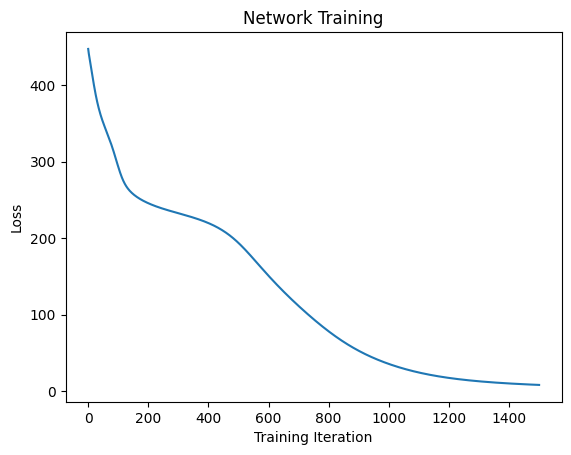

In [ ]:
num_training_samples = 500
num_testing_samples = num_training_samples

# get single task data for training
x_single_tasking, y_single_tasking = generate_data(num_samples=num_training_samples,
                                             single_tasking = True,
                                             multi_tasking = False)

# instantiate network
model = MultitaskingNet().to('cpu')

# initialize network
model = initialize_multitasking_network(model)

# train network
losses = train_multitasking_network(model,
                                    x_single_tasking,
                                    y_single_tasking,
                                    learning_rate = .01,
                                    training_iterations = 1500)

# plot loss across training iterations
plt.plot(losses)
plt.title("Network Training")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")

### Evaluating Multitasking Performance After Single-Task Trainining

Once trained, we can check how the network performs on executing single tasks and multiple tasks simultaneosuly. For both cases, we will sample a fresh batch of single task and multitasking patterns.

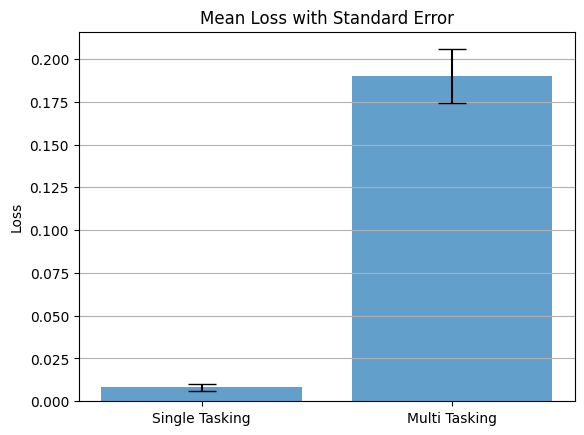

In [ ]:
def evaluate_performance(model):
  # get single task data for testing
  x_single_tasking, y_single_tasking = generate_data(num_samples=num_training_samples,
                                              single_tasking = True,
                                              multi_tasking = False)

  # get multitasking data for testing
  x_multi_tasking, y_multi_tasking = generate_data(num_samples=num_testing_samples,
                                              single_tasking = False,
                                              multi_tasking = True)

  # compute loss for single tasking
  y_pred_single_tasking, hidden_single_tasking = model(x_single_tasking)
  loss_single_tasking = (y_pred_single_tasking - y_single_tasking)**2
  loss_single_tasking = loss_single_tasking.detach().numpy()

  # compute loss for mulititasking
  y_pred_multi_tasking, hidden_multi_tasking = model(x_multi_tasking)
  loss_multi_tasking = (y_pred_multi_tasking - y_multi_tasking)**2
  loss_multi_tasking = loss_multi_tasking.detach().numpy()

  # Compute the mean for single tasking and multitasking losses
  mean_single_tasking = np.mean(loss_single_tasking)
  mean_multi_tasking = np.mean(loss_multi_tasking)

  # Compute the standard deviation for single tasking and multitasking losses
  std_single_tasking = np.std(loss_single_tasking)
  std_multi_tasking = np.std(loss_multi_tasking)

  # Compute the standard error for single tasking and multitasking losses
  sem_single_tasking = std_single_tasking / np.sqrt(len(loss_single_tasking))
  sem_multi_tasking = std_multi_tasking / np.sqrt(len(loss_multi_tasking))

  # Data for plotting
  labels = ['Single Tasking', 'Multi Tasking']
  means = [mean_single_tasking, mean_multi_tasking]
  errors = [sem_single_tasking, sem_multi_tasking]

  # Create the bar plot
  fig, ax = plt.subplots()

  ax.bar(labels, means, yerr=errors, align='center', alpha=0.7, ecolor='black', capsize=10)
  ax.set_ylabel('Loss')
  ax.set_title('Mean Loss with Standard Error')
  ax.yaxis.grid(True)

  # Show the plot
  plt.show()


evaluate_performance(model)



Not surprisingly, the model performs better on single tasking compared to multitasking (since it was trained on the former). That said, the point of this exercise is to examine *how well the model generalizes to multitasking as a function of its biases toward learning shared versus separated representations*.

### Exercise 2.2

Now it's your turn. Can you find a way to initialize the network, such that it is biased toward learning shared representations between tasks? What is the effect of such an ininitialization on multitasking performance?

The code block below will give you a head start.

**Hint**: You may want to tinker with the magnitude of the initial weights.

In [ ]:
# HINT: Modify this function to bias the network toward learning shared versus separated representations
def my_initialize_multitasking_network(model):
  with torch.no_grad():
    weight_scale = .1
    model.fc1.weight[:, :] = torch.rand((H, Din)) * (2 * weight_scale) - weight_scale
    model.fc2.weight[:, :] = torch.rand((Dout, H + Ningroup*Noutgroup)) * (2 * weight_scale) - weight_scale
    bias_init = -2
    model.fc1.bias[:] = torch.ones(H) * bias_init
    model.fc2.bias[:] = torch.ones(Dout) * bias_init

  return model

# The following function returns loss on multitasking performance after training
def evaluate_multitasking_performance():
    num_training_samples = 500
    num_testing_samples = num_training_samples

    # get single task data for training
    x_single_tasking, y_single_tasking = generate_data(num_samples=num_training_samples,
                                                single_tasking = True,
                                                multi_tasking = False)

    # get multitasking data for evaluation
    x_multi_tasking, y_multi_tasking = generate_data(num_samples=num_testing_samples,
                                              single_tasking = False,
                                              multi_tasking = True)

    # instantiate network
    model = MultitaskingNet().to('cpu')

    # initialize network
    model = my_initialize_multitasking_network(model)

    # train network
    train_multitasking_network(model,
                                x_single_tasking,
                                y_single_tasking,
                                learning_rate = .01,
                                training_iterations = 1500,
                                verbose = False)

    # evaluate multitasking performance of trained network
    y_pred_multi_tasking, hidden_multi_tasking = model(x_multi_tasking)
    loss_multi_tasking = (y_pred_multi_tasking - y_multi_tasking)**2
    loss_multi_tasking = loss_multi_tasking.detach().numpy()

    return loss_multi_tasking

# we can obtain the final testing loss on multitasking performance
loss_multi_tasking = evaluate_multitasking_performance()
print(np.mean(loss_multi_tasking))

0.18357345


#### Solution 1

One way to bias the network toward representation sharing verus separation is by controlling the magnitude of weight initialization, specifically from the task layer to the hidden layer. The code below assesses multitasking performance as a function of this magnitude.

Testing Weight Scale: 0.01
Testing Weight Scale: 0.12
Testing Weight Scale: 0.23
Testing Weight Scale: 0.34
Testing Weight Scale: 0.45
Testing Weight Scale: 0.56
Testing Weight Scale: 0.67
Testing Weight Scale: 0.78
Testing Weight Scale: 0.89
Testing Weight Scale: 1.0


Text(0.5, 1.0, 'Manipulation of Initial Weight Magnitude')

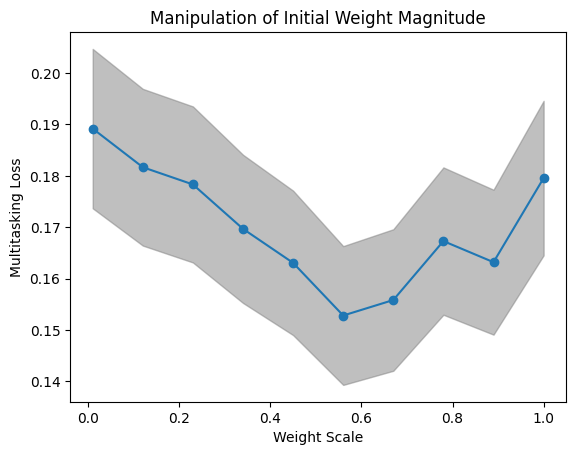

In [ ]:
weight_scales = np.linspace(0.01, 1, 10)

# HINT: Modify this function to bias the network toward learning shared versus separated representations
def my_initialize_multitasking_network(mode, weight_scale):
  with torch.no_grad():
    model.fc1.weight[:, :] = torch.rand((H, Din)) * (2 * weight_scale) - weight_scale
    model.fc2.weight[:, :] = torch.rand((Dout, H + Ningroup*Noutgroup)) * (2 * weight_scale) - weight_scale
    bias_init = -2
    model.fc1.bias[:] = torch.ones(H) * bias_init
    model.fc2.bias[:] = torch.ones(Dout) * bias_init

  return model

# The following function returns loss on multitasking performance after training
def evaluate_multitasking_performance(weight_scale):
    num_training_samples = 500
    num_testing_samples = num_training_samples

    # get single task data for training
    x_single_tasking, y_single_tasking = generate_data(num_samples=num_training_samples,
                                                single_tasking = True,
                                                multi_tasking = False)

    # get multitasking data for evaluation
    x_multi_tasking, y_multi_tasking = generate_data(num_samples=num_testing_samples,
                                              single_tasking = False,
                                              multi_tasking = True)

    # instantiate network
    model = MultitaskingNet().to('cpu')

    # initialize network
    model = my_initialize_multitasking_network(model, weight_scale)

    # train network
    train_multitasking_network(model,
                                x_single_tasking,
                                y_single_tasking,
                                learning_rate = .01,
                                training_iterations = 1500,
                                verbose = False)

    # evaluate multitasking performance of trained network
    y_pred_multi_tasking, hidden_multi_tasking = model(x_multi_tasking)
    loss_multi_tasking = (y_pred_multi_tasking - y_multi_tasking)**2
    loss_multi_tasking = loss_multi_tasking.detach().numpy()

    return loss_multi_tasking

mean_loss_multi_tasking = np.zeros(weight_scales.shape)
sem_loss_multi_tasking = np.zeros(weight_scales.shape)
for idx, weight_scale in enumerate(weight_scales):
  print("Testing Weight Scale: " + str(weight_scale))

  # compute mean and standard error
  losses_multi_tasking = evaluate_multitasking_performance(weight_scale)
  mean_loss_multi_tasking[idx] = np.mean(losses_multi_tasking)
  sem_loss_multi_tasking[idx] = np.std(losses_multi_tasking) / np.sqrt(len(losses_multi_tasking))


# Create the line plot
fig, ax = plt.subplots()

# Plot the mean loss as a line
ax.plot(weight_scales, mean_loss_multi_tasking, label='Mean Loss', marker='o')

# Add standard error shading
ax.fill_between(weight_scales, mean_loss_multi_tasking - sem_loss_multi_tasking, mean_loss_multi_tasking + sem_loss_multi_tasking, color='gray', alpha=0.5, label='SEM')

ax.set_xlabel("Weight Scale")
ax.set_ylabel("Multitasking Loss")
ax.set_title("Manipulation of Initial Weight Magnitude")


We should observe that the multitasking error decreases as we increase the weight scale. If the network is initialized with small weights, it starts out with shared representations between tasks (since all hidden activations for different tasks  will look quite similar).

**Note**: *If the network is initialized with too large weights, it may not be able to learn the single tasks at all (since changing the weights takes too many iterations), and thereby also fail at multitasking.*

#### Solution 2

A more elegant and more effective way to bias the network toward representation sharing is by manipulating the degree to which initial task representations in the hidden layer are correlated. In this case of this network, we may focus on introducing a greater correlation between tasks that share the same input dimension since this input dimension represented at the hidden layer.

Here, we one could manipulate the initial task correlation in the hidden layer by changing the weights projecting from each task unit to the hidden layer of the network. To facilitate this, we first write a function for generating random vectors according to some specified correlation r, via the Cholesky decomposition of the desired covariance matrix.

In [ ]:
import numpy as np

def generate_correlated_vectors(M, N, r):
    """
    Generate M random vectors of size N with correlation coefficient r.

    Parameters:
    M (int) : Number of random vectors to generate.
    N (int) : The size of each random vector.
    r (float) : Desired correlation coefficient between vectors. Should be between -1 and 1.

    Returns:
    np.ndarray : A NumPy array of shape (M, N) containing the M random vectors.
    """

    if r < -1 or r > 1:
        raise ValueError("Correlation coefficient should be between -1 and 1.")

    # Create the covariance matrix with the desired correlation coefficient
    cov_matrix = np.full((M, M), r)
    np.fill_diagonal(cov_matrix, 1)

    # Perform Cholesky decomposition
    cholesky_matrix = np.linalg.cholesky(cov_matrix)

    # Generate M independent random vectors of size N
    independent_vectors = np.random.randn(M, N)

    # Transform the independent vectors to get the correlated random vectors
    correlated_vectors = cholesky_matrix.dot(independent_vectors)

    return correlated_vectors

# Test the function
M = 3  # Number of vectors
N = 10  # Size of each vector
r = 0.4  # Correlation coefficient

vectors = generate_correlated_vectors(M, N, r)
print("Generated vectors:", vectors)
print(vectors.shape)

# Optionally, you can check the empirical correlation coefficient to see if it's close to r
empirical_corr_matrix = np.corrcoef(vectors)
print("Empirical correlation matrix:", empirical_corr_matrix)


Generated vectors: [[-5.79193734e-01  7.64084997e-01 -5.65270626e-01 -1.11010245e-01
   5.10006295e-02  6.37289237e-01 -4.29171058e-01  1.44592211e+00
  -4.19649790e-01 -7.56152157e-01]
 [ 4.74243162e-01 -1.11033648e+00  1.29851134e+00  1.01430195e+00
  -1.39417825e-01  1.47427878e+00 -4.73777899e-01  3.10801467e-02
  -1.66392246e-03 -7.79310335e-02]
 [ 3.89654042e-01  7.55768026e-01  4.12177780e-01 -1.59712610e+00
   7.87062331e-01  2.53885545e+00 -1.44100798e+00  9.09104677e-01
  -2.75678123e-01  2.56703600e-01]]
(3, 10)
Empirical correlation matrix: [[ 1.         -0.13964083  0.49052458]
 [-0.13964083  1.          0.21769499]
 [ 0.49052458  0.21769499  1.        ]]


In the initialization function below, we manipulate the similarity between tasks that share an input dimension. Those are tasks:
- (1,2,3)
- (4,5,6)
- (7,8,9)
- (10,11,12)

For each set of of those tasks, we will randomly generate the weights projecting from the respective unit in the task input layer to the hidden layer.
Uusing our vector generation function above, we can ensure that the respective weight vectors adhere to the specified correlation.

Testing Correlation Coefficient: 0.1
Testing Correlation Coefficient: 0.18888888888888888
Testing Correlation Coefficient: 0.2777777777777778
Testing Correlation Coefficient: 0.3666666666666667
Testing Correlation Coefficient: 0.4555555555555556
Testing Correlation Coefficient: 0.5444444444444445
Testing Correlation Coefficient: 0.6333333333333333
Testing Correlation Coefficient: 0.7222222222222222
Testing Correlation Coefficient: 0.8111111111111111
Testing Correlation Coefficient: 0.9


<ipython-input-42-5d00454de05d>:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Text(0.5, 1.0, 'Manipulation of Initial Task Weight Correlation')

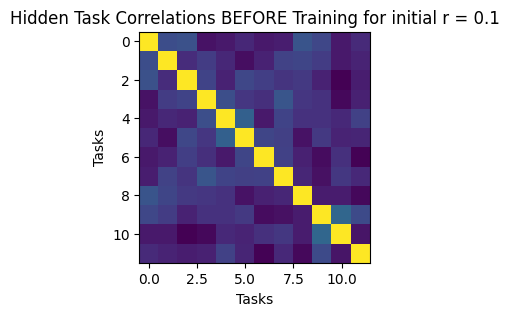

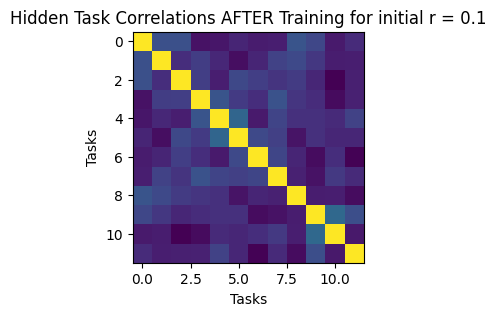

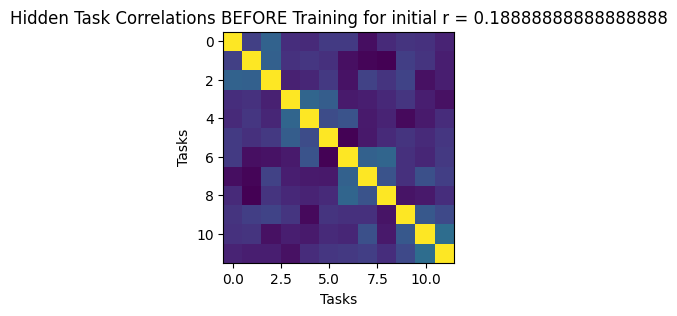

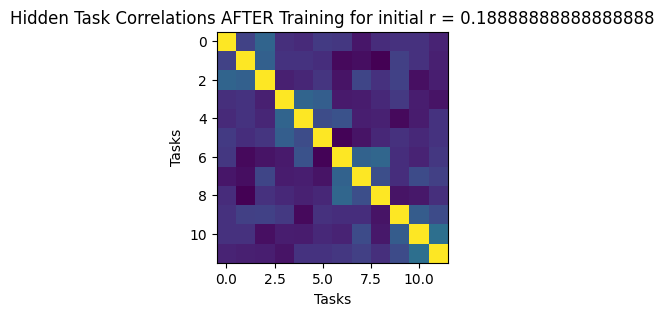

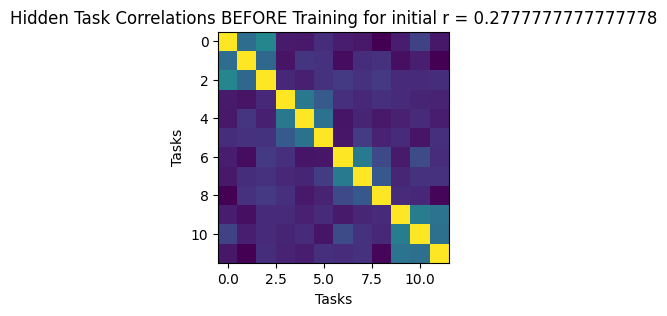

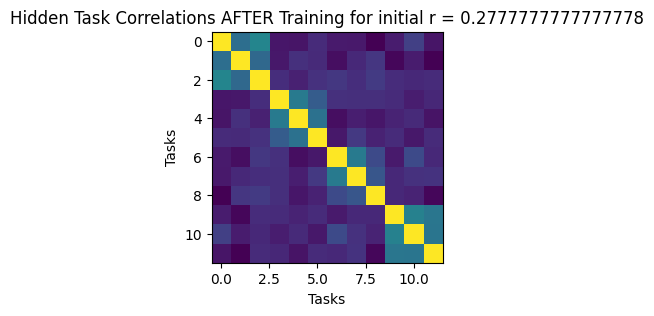

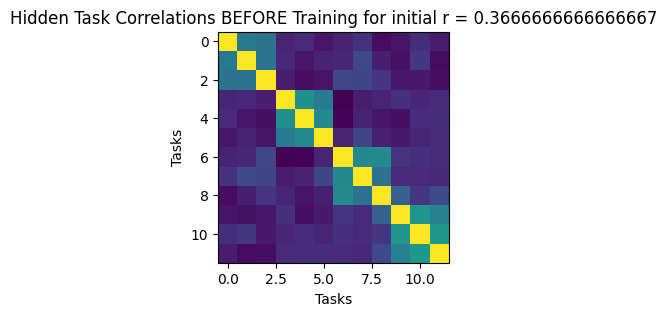

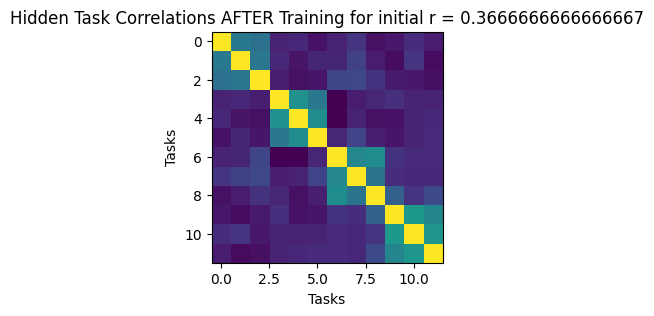

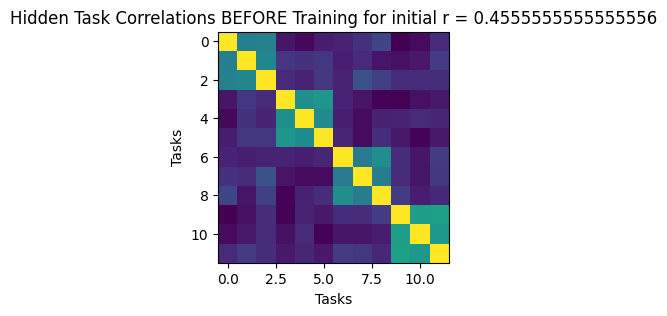

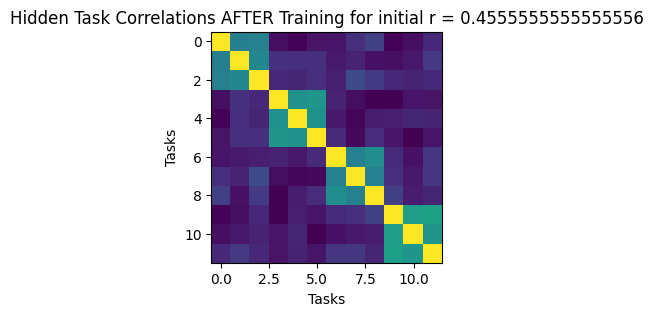

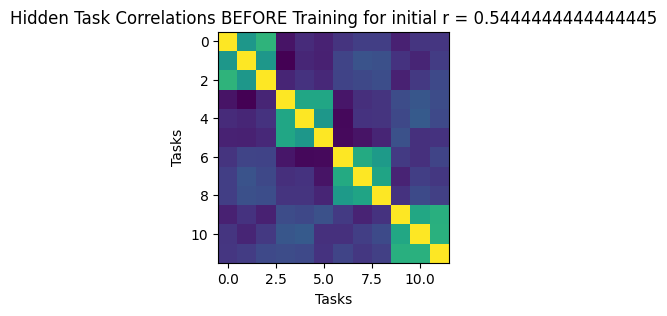

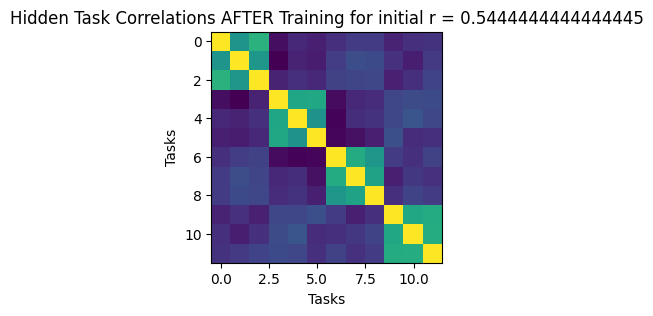

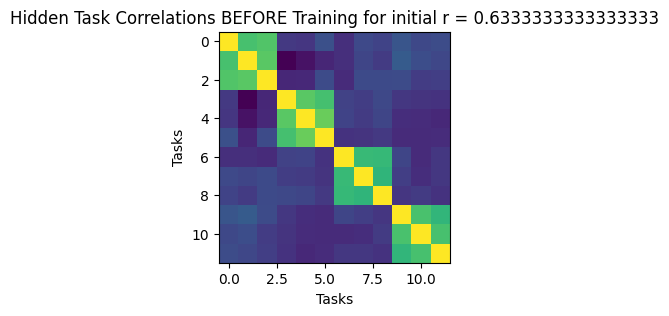

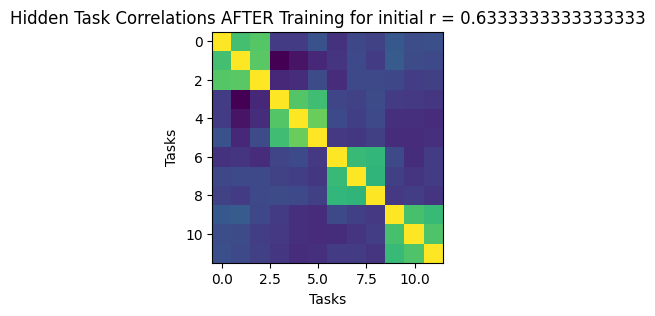

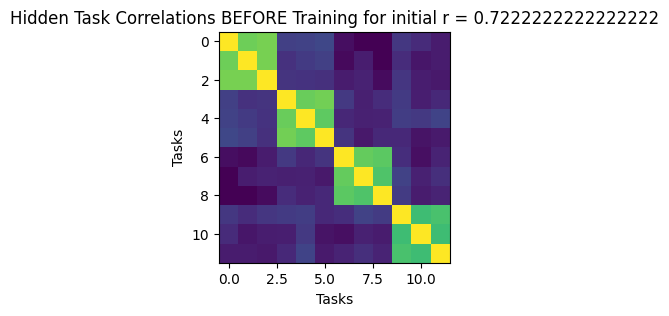

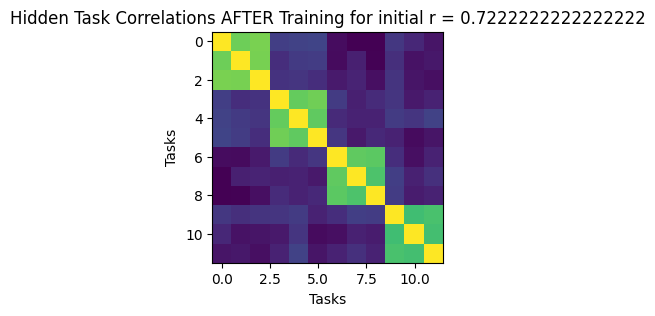

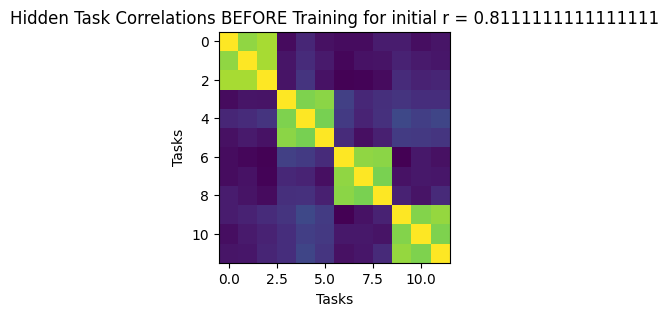

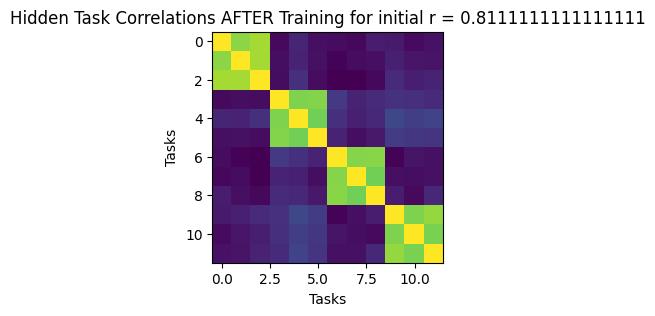

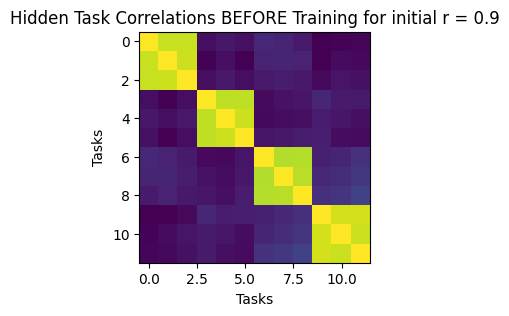

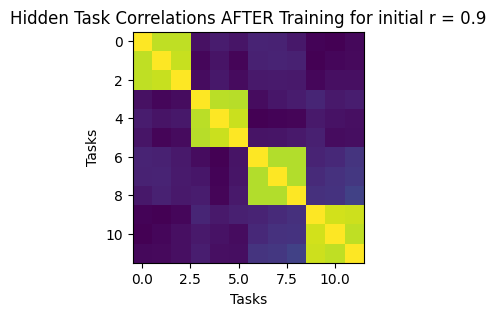

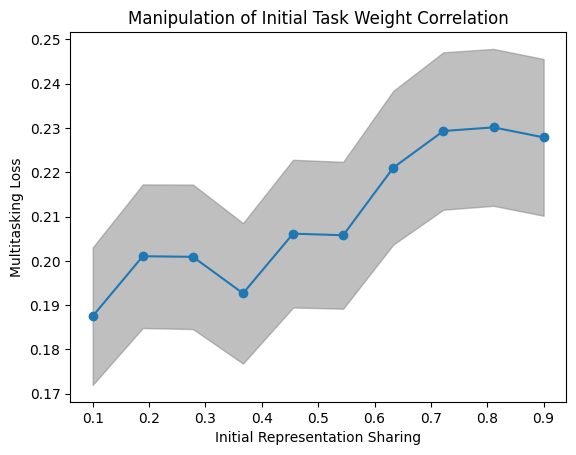

In [ ]:
correlation_coefficients = np.linspace(0.1, 0.9, 10)

def my_initialize_multitasking_network(model, correlation_coefficient = 0.5):
  with torch.no_grad():
    weight_scale = 1

    M = 3  # Number of vectors
    N = H  # Size of each vector
    r = correlation_coefficient

    # group (1,2,3)
    vectors = generate_correlated_vectors(M, N, r)
    model.fc1.weight[:, (Ningroup*Nfeatures)+0] = torch.from_numpy(vectors[0,:])
    model.fc1.weight[:, (Ningroup*Nfeatures)+1] = torch.from_numpy(vectors[1,:])
    model.fc1.weight[:, (Ningroup*Nfeatures)+2] = torch.from_numpy(vectors[2,:])

    # group (4,5,6)
    vectors = generate_correlated_vectors(M, N, r)
    model.fc1.weight[:, (Ningroup*Nfeatures)+3] = torch.from_numpy(vectors[0,:])
    model.fc1.weight[:, (Ningroup*Nfeatures)+4] = torch.from_numpy(vectors[1,:])
    model.fc1.weight[:, (Ningroup*Nfeatures)+5] = torch.from_numpy(vectors[2,:])

    # group (7,8,9)
    vectors = generate_correlated_vectors(M, N, r)
    model.fc1.weight[:, (Ningroup*Nfeatures)+6] = torch.from_numpy(vectors[0,:])
    model.fc1.weight[:, (Ningroup*Nfeatures)+7] = torch.from_numpy(vectors[1,:])
    model.fc1.weight[:, (Ningroup*Nfeatures)+8] = torch.from_numpy(vectors[2,:])

    # group (10,11,12)
    vectors = generate_correlated_vectors(M, N, r)
    model.fc1.weight[:, (Ningroup*Nfeatures)+9] = torch.from_numpy(vectors[0,:])
    model.fc1.weight[:, (Ningroup*Nfeatures)+10] = torch.from_numpy(vectors[1,:])
    model.fc1.weight[:, (Ningroup*Nfeatures)+11] = torch.from_numpy(vectors[2,:])

    model.fc1.weight[:, :] = model.fc1.weight[:, :]  * (2 * weight_scale) - weight_scale
    model.fc2.weight[:, :] = torch.rand((Dout, H + Ningroup*Noutgroup)) * (2 * weight_scale) - weight_scale
    bias_init = -2
    model.fc1.bias[:] = torch.ones(H) * bias_init
    model.fc2.bias[:] = torch.ones(Dout) * bias_init

    task_hidden_weights = model.fc1.weight[:, (Ningroup*Nfeatures):]
    R = np.corrcoef(task_hidden_weights.T)

    # plot correlation matrix of initial task weight vectors (before training)
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    axes.imshow(R)
    axes.set_title("Hidden Task Correlations BEFORE Training for initial r = " + str(correlation_coefficient))
    axes.set_xlabel("Tasks")
    axes.set_ylabel("Tasks")

  return model

# The following function returns loss on multitasking performance after training
def evaluate_multitasking_performance(correlation_coefficient):
    num_training_samples = 500
    num_testing_samples = num_training_samples

    # get single task data for training
    x_single_tasking, y_single_tasking = generate_data(num_samples=num_training_samples,
                                                single_tasking = True,
                                                multi_tasking = False)

    # get multitasking data for evaluation
    x_multi_tasking, y_multi_tasking = generate_data(num_samples=num_testing_samples,
                                              single_tasking = False,
                                              multi_tasking = True)

    # instantiate network
    model = MultitaskingNet().to('cpu')

    # initialize network
    model = my_initialize_multitasking_network(model, correlation_coefficient)

    # train network
    train_multitasking_network(model,
                                x_single_tasking,
                                y_single_tasking,
                                learning_rate = .01,
                                training_iterations = 1500,
                                verbose = False)

    # plot correlation matrix of final task weight vectors (after training)
    task_hidden_weights = model.fc1.weight[:, (Ningroup*Nfeatures):]
    R = np.corrcoef(task_hidden_weights.detach().numpy().T)
    fig, axes = plt.subplots(1, 1, figsize=(3, 3))
    axes.imshow(R)
    axes.set_title("Hidden Task Correlations AFTER Training for initial r = " + str(correlation_coefficient))
    axes.set_xlabel("Tasks")
    axes.set_ylabel("Tasks")

    # evaluate multitasking performance of trained network
    y_pred_multi_tasking, hidden_multi_tasking = model(x_multi_tasking)
    loss_multi_tasking = (y_pred_multi_tasking - y_multi_tasking)**2
    loss_multi_tasking = loss_multi_tasking.detach().numpy()

    return loss_multi_tasking

mean_loss_multi_tasking = np.zeros(correlation_coefficients.shape)
sem_loss_multi_tasking = np.zeros(correlation_coefficients.shape)
for idx, corr_coeff in enumerate(correlation_coefficients):
  print("Testing Correlation Coefficient: " + str(corr_coeff))

  # compute mean and standard error
  losses_multi_tasking = evaluate_multitasking_performance(corr_coeff)
  mean_loss_multi_tasking[idx] = np.mean(losses_multi_tasking)
  sem_loss_multi_tasking[idx] = np.std(losses_multi_tasking) / np.sqrt(len(losses_multi_tasking))


# Create the line plot
fig, ax = plt.subplots()

# Plot the mean loss as a line
ax.plot(correlation_coefficients, mean_loss_multi_tasking, label='Mean Loss', marker='o')

# Add standard error shading
ax.fill_between(correlation_coefficients, mean_loss_multi_tasking - sem_loss_multi_tasking, mean_loss_multi_tasking + sem_loss_multi_tasking, color='gray', alpha=0.5, label='SEM')

ax.set_xlabel("Initial Representation Sharing")
ax.set_ylabel("Multitasking Loss")
ax.set_title("Manipulation of Initial Task Weight Correlation")

### Exercise 2.3

Another way of altering the network's multitasking capability is chaing its training data. Here, instead of training the network to perform single tasks, we can instead train it to exeute single tasks as well as multiple tasks simultaneously.

Let's consider the following two types of training sets.

Text(0.5, 1.0, 'Example Task Input for Single + Multitasking')

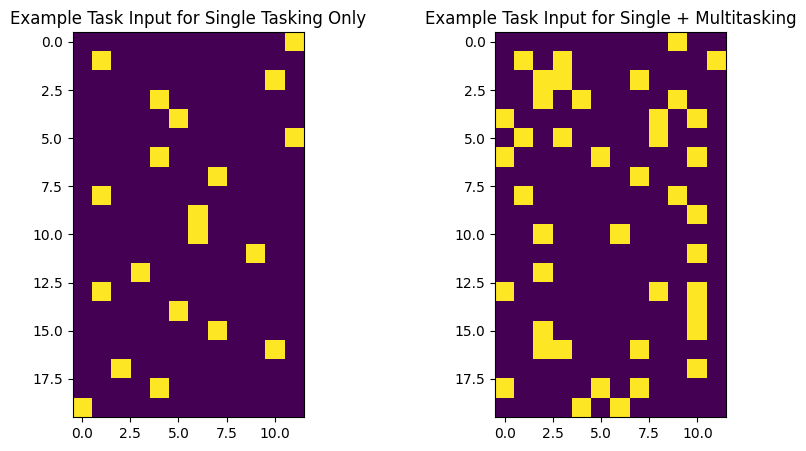

In [ ]:
# obtain patterns for single tasking training alone
x_single_tasking, y_single_tasking = generate_data(num_samples=20,
                                             single_tasking = True,
                                             multi_tasking = False)

# obtain patterns for single + multitasking training
x_single_multi_tasking, y_single_multi_tasking = generate_data(num_samples=20,
                                             single_tasking = True,
                                             multi_tasking = True)

# extract the input to the task layer
single_tasking_task_input = x_single_tasking[:, (Ningroup*Nfeatures):]
single_multi_tasking_task_input = x_single_multi_tasking[:, (Ningroup*Nfeatures):]


# Create a single figure and a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the first subplot
axes[0].imshow(single_tasking_task_input)
axes[0].set_title("Example Task Input for Single Tasking Only")

# Plot the second image on the second subplot
axes[1].imshow(single_multi_tasking_task_input)
axes[1].set_title("Example Task Input for Single + Multitasking")

In this exercise, we ask you to examine the 12 single task representations at the hidden layer as a function of the training regime. You may use your favorite visualization method to examine how the different task representations relate to one another, both in the case of (a) single tasking only, and (b) single tasking + multitasking.

Recall the following arrangement of tasks in the environment:

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/main/FIG_ENV.png?raw=true'
alt="Network Architecture and Training Environment" width=500px height=auto/></p>

For instance, tasks 1-3 are likely to be represented similarly in the hidden layer of the network as they share the same stimulus representation. Can you recover this similarity from your plot? You may use your favorite dimensionality reduction method to show your results.

Feel free to use the following code as a starting point for your analysis.

In [ ]:
def get_single_task_representations(model,
                                    input_patterns):
  '''
  This function computes the average activity at the hidden layer of the network for each task.
  '''

  # average activity vectors are # of tasks (# input dimensions x # output dimensions)
  # times the number of hidden units H
  Ntasks = Ningroup * Noutgroup
  task_representations = np.zeros((Ntasks, H))

  # iterate through tasks
  for task in range(Ntasks):
    # iterate through input patterns
    for pattern_idx in range(input_patterns.size(0)):
      # empty the 12 task units
      input_patterns[pattern_idx, (Ningroup*Nfeatures):] = torch.zeros(1, Ntasks)
      # only active current task
      input_patterns[pattern_idx, (Ningroup*Nfeatures)+task] = 1

    # obtain hidden activations for current tasks across all stimuli
    output, hidden = model(input_patterns)
    hidden = hidden.detach().numpy()

    # average hidden activations across all stimuli and store resulting task representation
    task_representations[task,:] = np.mean(hidden, axis=0)

  return task_representations

In [ ]:
# get single task data for training
x_single_tasking, y_single_tasking = generate_data(num_samples=num_training_samples,
                                            single_tasking = True,
                                            multi_tasking = False)

# instantiate network
model = MultitaskingNet().to('cpu')

# initialize network
model = initialize_multitasking_network(model)

# train network
train_multitasking_network(model,
                            x_single_tasking,
                            y_single_tasking,
                            learning_rate = .01,
                            training_iterations = 1500,
                            verbose = False)

# obtain single task representations for trained network
task_representations = get_single_task_representations(model, x_single_tasking)

# CONTINUE HERE


#### Solution

You should observe that the tasks sharing the same input dimension (e.g., tasks 1-3) form similar representations at the hidden layer, at least when trained to perform single tasks:

Text(0, 0.5, 'Tasks')

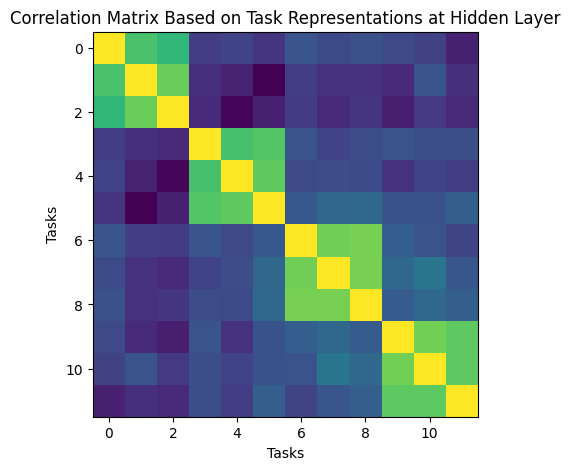

In [ ]:
# get single task data for training
x_single_tasking, y_single_tasking = generate_data(num_samples=num_training_samples,
                                            single_tasking = True,
                                            multi_tasking = False)

# instantiate network
model = MultitaskingNet().to('cpu')

# initialize network
model = initialize_multitasking_network(model)

# train network
train_multitasking_network(model,
                            x_single_tasking,
                            y_single_tasking,
                            learning_rate = .01,
                            training_iterations = 1500,
                            verbose = False)

# obtain single task representations for trained network
task_representations = get_single_task_representations(model, x_single_tasking)

# compute correlation matrix for task representations
R = np.corrcoef(task_representations)

# plot correlation matrix
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.imshow(R)
axes.set_title("Correlation Matrix Based on Task Representations at Hidden Layer")
axes.set_xlabel("Tasks")
axes.set_ylabel("Tasks")

Conversely, if the network is trained on both single-tasking and multi-tasking the representations for single tasks tend to separate:

Text(0, 0.5, 'Tasks')

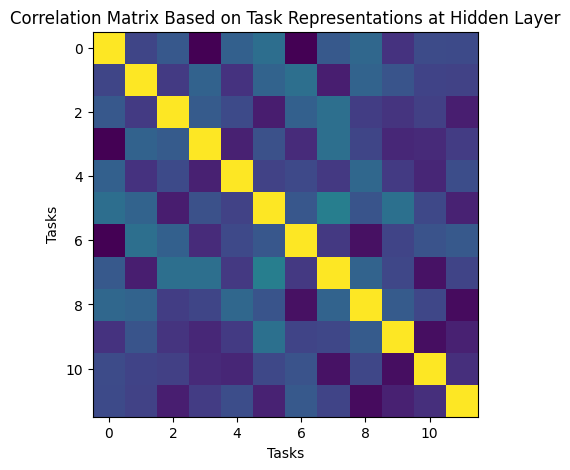

In [ ]:
# get single task data for training
x_single_tasking, y_single_tasking = generate_data(num_samples=num_training_samples,
                                            single_tasking = True,
                                            multi_tasking = True)

# instantiate network
model = MultitaskingNet().to('cpu')

# initialize network
model = initialize_multitasking_network(model)

# train network
train_multitasking_network(model,
                            x_single_tasking,
                            y_single_tasking,
                            learning_rate = .01,
                            training_iterations = 1500,
                            verbose = False)

# obtain single task representations for trained network
task_representations = get_single_task_representations(model, x_single_tasking)

# compute correlation matrix for task representations
R = np.corrcoef(task_representations)

# plot correlation matrix
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.imshow(R)
axes.set_title("Correlation Matrix Based on Task Representations at Hidden Layer")
axes.set_xlabel("Tasks")
axes.set_ylabel("Tasks")

This observation is replicating neuroimaging findings by Garner & Dux:

Garner, K. G., & Dux, P. E. (2015). Training conquers multitasking costs by dividing task representations in the frontoparietal-subcortical system. *Proceedings of the National Academy of Sciences, 112*(46), 14372-14377.

In their work, the authors trained participants to perform tasks either sequentially or in parallel. When trained to perform the tasks in parallel, they could observe that greater separation between the tasks was associated with better multitasking performance.

## Section 3: Graph-Theoretic Analyses of Parallel Processing in Networks

In order to pursue a more rigorous analysis of the relationship between shared representations and the multitasking capability of a network, we will consider networks as simple bipartite graphs.

### Bipartite Graphs and Dependency Grahps

**Bipartite graph**.  This is a simplified representation of the three-layered networks used in Section 2 above that focuses on the hidden and output layers.  A given network configuration can be represented as a directed bipartite graph $G_B = (I, O, T)$, in which each input node I represents a subset of hidden representations (corresponding to associative dimensions in the original network), each output node $O$ represents a response dimension, and edges between them represent the tasks (see the left bottom of each panel in the figure below). Two tasks are considered to be **structurally** dependent if their edges share either an input node or an output node (e.g., the color naming task and the word reading task in the Figure below both share the same output node and are thus considered to be structurally dependent). In contrast, two tasks are considered to be  **functionally** dependent if they are not structurally dependent, but an edge (a third task) connects the input node of one task to the output node of the other (e.g., the edge representing the word reading task connects the color naming and word mapping tasks in the bipartite task graph in Panel A of the figure below).

**Dependency Graph**. Using the bipartite graph described above, a dependency graph can be constructed that directly expresses relationships between tasks.  This is constructed by assigning each edge of the original graph $G_B$ to a node in the dependency graph $G_D$. Thus, each node in $G_D$ represents a task in $G_B$ (and in the original network). Edges are assigned between any two nodes in $G_D$ representing tasks in $G_B$ that are either structurally or functionally dependent (see the right bottom of each panel in the figure below), as defined above. For simplicity, we assume that either form of dependence introduces a risk of interference that precludes those two tasks from safely being executed in parallel. Thus, the dependency graph $G_D$ can be used to determine which tasks in the original network can be executed safely in parallel.

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/main/FIG_GRAPH_ANALYSIS.png?raw=true'
alt="Network Architecture and Training Environment" width=1000px height=auto/></p>

The figure above depicts examples of networks exhibiting each form of dependence among tasks in the extended Stroop paradigm and their graph-theoretic representation. Note, however, that the connections from the task layer are not shown. Each network implements four tasks: color naming, word reading, and word mapping (i.e., mapping a word to a button press). Color naming and word reading are structurally dependent since both share the same response dimension, and thus cannot be performed simultaneously.  However, color naming and word mapping can be either functionally dependent or fully independent, based on the network configuration–that is, whether a compositional or a conjunctive configuration is used for the representations required to perform the word reading and word mapping tasks, as shown in the Neural Network Models in Panels A and B.  This determines whether they can be multitasked.

In **Panel A** of the figure above, the word mapping task shares a representation for words with the word reading task at the hidden layer, which introduces functional dependence between it and the color naming task, thus precluding multitasking.

In **Panel B**, Word Mapping relies on a separate set of representations for words in the hidden layer, rendering color naming and word mapping functionally independent, thus permitting multitasking.

Each configuration has a corresponding *bipartite task graph* (middle part of each panel), with nodes representing stimulus and response dimensions, and edges representing the tasks (i.e., the mappings from features in a given stimulus dimension to corresponding responses in the response dimension that define that task). The corresponding *dependency graph* represents the relationship between tasks, with nodes now corresponding to tasks, and edges indicating tasks are dependent on (i.e., interact with) one another. The solid and dashed lines in the dependency graph indicate structural and functional dependence between two tasks, respectively.

### Exercise 3.1

In order to quantify the multitasking capability of the network, it is convenient to convert bipartite task graphs into a dependency graphs. Your task is to implement a function that performs this conversion.

In [ ]:
def bipartite_to_dependency(adjacency_matrix_of_bipartite_graph):

  A = adjacency_matrix_of_bipartite_graph
  # YOUR CODE HERE
  dependency_graph = A

  return dependency_graph

# bipartite graph with 4 input nodes and 3 output nodes (corresponding to the network in the previous sections)
bipartite_graph = np.array([[1, 0, 0],
                            [0, 1, 0],
                            [1, 0, 1],
                            [0, 1, 0]])

dependency_graph = bipartite_to_dependency(bipartite_graph)
print(dependency_graph)

[[1 0 0]
 [0 1 0]
 [1 0 1]
 [0 1 0]]


Remember: In the *adjacency matrix of the bipartite graph*, input representations correspond to input nodes (rows) and output representations correspond to output nodes (columns). Tasks correspond to edges (matrix entries).

In the symmetric *adjacency matrix of the dependency graph*, tasks correspond to nodes (rows and columns) and dependencies correspond to edges (matrix entries).


#### Solution

The following code implements the conversion. It's not the most efficient solution but does the job.

In [ ]:
def bipartite_to_dependency(adjacency_matrix_of_bipartite_graph):

  A = adjacency_matrix_of_bipartite_graph

  # determine number of tasks
  num_tasks = int(np.sum(A.flatten()))

  # for each of the tasks below, let's us store their input and output dimensions
  # these will come in handy later on
  task_list = list()
  for row in range(A.shape[0]):
    for col in range(A.shape[1]):
      if A[row, col] == 1: # we found a task
        # we are appending each task as a tuple specifying its input and output dimension
        task_list.append((row, col))

  # set up dependency graph
  dependency_graph = np.eye(num_tasks)

  # we will now enumerate through each pair of tasks
  for task1_id, input_output_tuple1 in enumerate(task_list):
    for task2_id, input_output_tuple2 in enumerate(task_list):
      if task1_id == task2_id:
        continue

      dependency = 0 # let's begin with assuming no dependency

      # first check if the two tasks are structurally dependent,
      # i.e., whether they share an input or output dimension
      if input_output_tuple1[0] == input_output_tuple2[0] or input_output_tuple1[1] == input_output_tuple2[1]:
        dependency = 1

      if dependency == 0:
        # if the task is not structurally dependent, then it may be functionally dependent
        # to determine functional dependence, we have to check if there is a third task in A
        # that either shares an input dimension our an output dimension with our task
        for task3_id, input_output_tuple3 in enumerate(task_list):
          if (input_output_tuple3[0] == input_output_tuple1[0] and input_output_tuple3[1] == input_output_tuple2[1]) or (input_output_tuple3[0] == input_output_tuple2[0] and input_output_tuple3[1] == input_output_tuple1[1]):
            dependency = 1
            break

      dependency_graph[task1_id, task2_id] = dependency
      dependency_graph[task2_id, task1_id] = dependency

  return dependency_graph

# bipartite graph with 4 input nodes and 3 output nodes (corresponding to the network in the previous sections)
bipartite_graph = np.array([[1, 0, 0],
                            [0, 1, 0],
                            [1, 0, 1],
                            [0, 1, 0]])

dependency_graph = bipartite_to_dependency(bipartite_graph)
print(dependency_graph)


[[1. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1.]]


### Quantifying Multitasking Capability: The Maximum Independent Set

The dependency graph $G_D$ can be used to analyze the multitasking capability of a network.

**Maximum independent set**.  The definitive way to determine the multitasking capability of a network is to identify the largest set of nodes (tasks) in $G_D$ that do not share any edges (i.e., that are not dependent on one another).  This is known as the *maximum independent set* (MIS) of a graph.

Here, we will use the cardinality (i.e., set size) of the MIS to quantify the maximum number of tasks that a bipartite graph can perform in parallel.

Unfortunately, *computing the MIS is an NP-hard problem*, so we can either approximate it or bruteforce it. In this case, we will bruteforce its computation, with the caveat that we cannot compute it over dependency graphs with too many nodes.

The following code computes the MIS. There is no need to understand the code in detail, we will just use it for the next exercise.



In [ ]:
import itertools

def is_independent_set(adjacency_matrix, node_set):
    """Check if a set of nodes is an independent set."""
    for i in node_set:
        for j in node_set:
            if i != j and adjacency_matrix[i, j] == 1:
                return False
    return True

def maximum_independent_set(adjacency_matrix, verbose = False):
    """Find the maximum independent set of a graph given its adjacency matrix."""
    n = len(adjacency_matrix)
    max_set = set()

    for size in range(1, n + 1):
        for subset in itertools.combinations(range(n), size):
            if verbose:
              print(str(subset) + str(is_independent_set(adjacency_matrix, subset)))
            if is_independent_set(adjacency_matrix, subset):
                if len(subset) > len(max_set):
                    max_set = set(subset)
    return max_set

def get_MIS_cardinality(adjacency_matrix):
  """determine the cardinality of the maximum independent set"""
  max_set = maximum_independent_set(adjacency_matrix)

  return len(max_set)


adjacency_matrix = np.array([
                            [1, 0, 1, 1, 0],
                            [0, 1, 0, 0, 1],
                            [1, 0, 1, 1, 0],
                            [1, 0, 1, 1, 0],
                            [0, 1, 0, 0, 1]
])

max_ind_set = maximum_independent_set(adjacency_matrix)
MIS_size = get_MIS_cardinality(adjacency_matrix)
print("Maximum Independent Set:", max_ind_set)
print("MIS cardinality: " + str(MIS_size))


Maximum Independent Set: {0, 1}
MIS cardinality: 2


### Exercise 3.2

Let the cardinality of the maximum independent set $\vert \text{MIS} \vert$ correspond to the maximum number of tasks that a corresponding bipartite graph can perform simultaneosuly. How does the amount of representation sharing in a graph impact its multitasking capability?

For this exercise, we assume the same number of input and output nodes. For each bipartite task graph, we will connect each input node to its corresponding output node, resulting in an identiy matrix as the adjacency matrix of the bipartite graph, $A_\text{bipartite}$.



In [ ]:
num_nodes = 5

bipartite_graph = np.eye(num_nodes)

print(bipartite_graph)


[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


Further, for simplicity, we define representation sharing probabilistically. Let $p$ be the probability of an edge for any non-diagnoal element in $A_\text{bipartite}$. By adding edges, the likelyhood of two edges sharing an input or output node (i.e., sharing a representation in the network) increases.

In [ ]:
def add_shared_representations(adjacency_matrix, p):
  for row in range(adjacency_matrix.shape[0]):
    for col in range(adjacency_matrix.shape[1]):
      if row == col:
        continue
      else:
        randnum = np.random.rand()
        if randnum < p:
          adjacency_matrix[row, col] = 1
          adjacency_matrix[col, row] = 1
  return adjacency_matrix

In [ ]:
num_nodes = 5

bipartite_graph = np.eye(num_nodes)

print("Bipartite Graph Without Shared Representations")
print(bipartite_graph)

bipartite_graph = add_shared_representations(bipartite_graph, p = 0.2)
print("Bipartite Graph With Shared Representations")
print(bipartite_graph)

Bipartite Graph Without Shared Representations
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Bipartite Graph With Shared Representations
[[1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 1.]]


1. Given this metric, can you show that the parallel processing capability of a bipartite task decreases with the amount of representation sharing (i.e., number of edges probabilistically added to the network)?

2. How does the parallel processing capability of a graph scale with the number of nodes in the network?

**Note**: *For this exercise it is advisable to not consider networks with more than 5 input nodes. You may use the following values:*

In [ ]:
N_list = [2, 3, 4, 5] # number of nodes probed
p_list = [0, .25, .5, .75] # edge probabilities probed

#### Solution

The following code computes the parallel processing capability as a function of representation sharing (edge probability $p$) and network size (number of nodes $N$).

In [ ]:
N_list = [2, 3, 4, 5] # number of nodes probed
p_list = [0, .25, .5, .75] # edge probabilities probed

num_samples = 10

collected_data = np.zeros((len(N_list), len(p_list)))

# loop across all network sizes
for N_idx, N in enumerate(N_list):
  print("Processing network size: " + str(N))

  # loop across all edge probabilities
  for p_idx, p in enumerate(p_list):
    print("Processing edge probability: " + str(p))

    # this is for storing the MIS size for each sample
    MIS_list = np.zeros((1, num_samples))

    # loop across samples
    for sample in range(num_samples):
        bipartite_graph = np.eye(N)
        bipartite_graph = add_shared_representations(bipartite_graph, p)
        dependency_graph = bipartite_to_dependency(bipartite_graph)
        MIS_size = get_MIS_cardinality(dependency_graph)
        MIS_list[0,sample] = MIS_size

    collected_data[N_idx, p_idx] = np.mean(MIS_list)



Processing network size: 2
Processing edge probability: 0
Processing edge probability: 0.25
Processing edge probability: 0.5
Processing edge probability: 0.75
Processing network size: 3
Processing edge probability: 0
Processing edge probability: 0.25
Processing edge probability: 0.5
Processing edge probability: 0.75
Processing network size: 4
Processing edge probability: 0
Processing edge probability: 0.25
Processing edge probability: 0.5
Processing edge probability: 0.75
Processing network size: 5
Processing edge probability: 0
Processing edge probability: 0.25
Processing edge probability: 0.5
Processing edge probability: 0.75


In [ ]:
collected_data

array([[2. , 1.5, 1.3, 1.1],
       [3. , 2.3, 1.4, 1.3],
       [4. , 2.6, 1.9, 1.2],
       [5. , 2.9, 2.1, 1.7]])

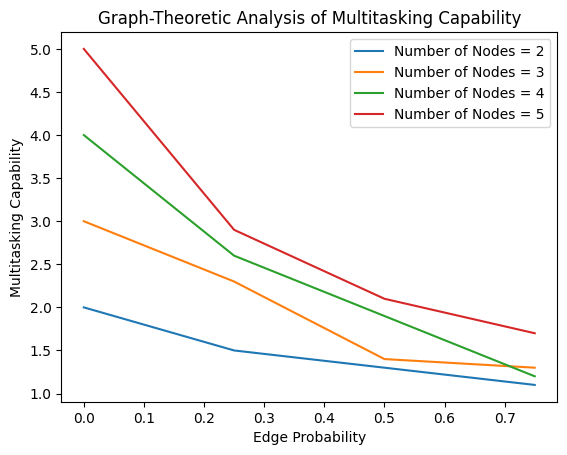

In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each row in the collected_data array
for i, row_data in enumerate(collected_data):
    ax.plot(p_list, row_data, label="Number of Nodes = " + str(N_list[i]))

# Add title and labels
ax.set_title('Graph-Theoretic Analysis of Multitasking Capability')
ax.set_xlabel('Edge Probability')
ax.set_ylabel('Multitasking Capability')

# Add a legend
ax.legend()

# Show the plot
plt.show()

You may observe that the mulitasking capability of the bipartite graph shrinks with the likelihood of edges in the graph. Notably, the effect of adding nodes (i.e., increasing the structural capacity of the network) diminishes with edge probability. In other words: It may not help to make the brain bigger--if there is a high probability neural pathways overlapping, then our multitasking capability is fairly limited, irrespective of brain size.

### Exercise 3.3

What happens if we add more layers to our network? Assume a network of a fixed size $N = 5$ with an edge probaility of $p = .2$.

1. We begin with a theoretical exercise. Think about how to compute an upper bound on the multitasking capability of a multi-layered graph.

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/main/FIG_MULTI_LAYER.png?raw=true'
alt="Network Architecture and Training Environment" width=500px height=auto/></p>

For a multi-layered graph, **a task** corresponds to a series of edges, connecting an input in the first layer to an output dimension in the last layer. For simplicity, we assume that all edges are directed, i.e., that a task can only traverse from layer $L$ to layer $L+1$ and never back. We call this series of edges a **path**.

As before, we consider two tasks to interfere with one another, if there is any form of dependence between two paths, at any point in the network.

How would one compute an bound for the multitasking capability of a multi-layered graph? *Hint: A multi-layered graph is can be considered a stack of multiple bipartite  graphs (see Figure).*



#### Solution

The total multitasking capability of a multi-layered net cannot be grater than the multitasking capability of any subsequent two layers within it. Thus, an upper bound for the multitasking capability of a multi-layered net can be computed by determining the smallest $\vert \text{MIS} \vert$ across every subsequent two layers in the graph.

### Exercise 3.4

Building on the solutions to Exercise 3.2 and Exercise 3.3, can you show that increases in network depth lead to reductions in multitasking capability?

For this exercise, you may consider graphs between 2 and 30 layers. You can fix the number of nodes in each layer to $N = 5$ and assume an edge probaility of $p = .2$.




#### Solution

The following code determines the multitasking capability for a network with varying depths.

In [ ]:
depth_list = [2, 10, 20, 30] # depths
N = 5
p = 0.1

num_samples = 10

collected_data = np.zeros((1, len(depth_list)))

# loop across all network depths
for depth_idx, depth in enumerate(depth_list):
  print("Processing network depth: " + str(depth))

  # this is for storing the MIS size for each sample
  MIS_list = np.zeros((1, num_samples))

  # loop across samples
  for sample in range(num_samples):

    smallest_MIS = N
    for d in range(depth):

      bipartite_graph = np.eye(N)
      bipartite_graph = add_shared_representations(bipartite_graph, p)
      dependency_graph = bipartite_to_dependency(bipartite_graph)
      MIS_size = get_MIS_cardinality(dependency_graph)
      smallest_MIS = np.min([MIS_size, smallest_MIS])


    MIS_list[0,sample] = smallest_MIS

  collected_data[0, depth_idx] = np.mean(MIS_list)



Processing network depth: 2
Processing network depth: 10
Processing network depth: 20
Processing network depth: 30


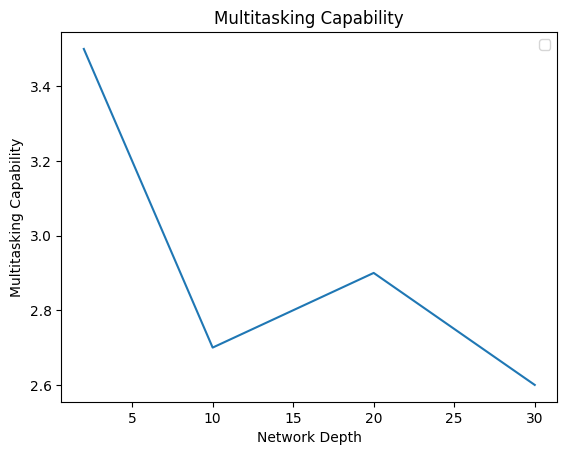

In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots()

ax.plot(depth_list, collected_data[0,:],)

# Add title and labels
ax.set_title('Multitasking Capability')
ax.set_xlabel('Network Depth')
ax.set_ylabel('Multitasking Capability')

# Add a legend
ax.legend()

# Show the plot
plt.show()

One should observe that the multitasking capability decreases with increases in network depth.

### (Optional) Exercise 3.5

In this extended exercise, you will build on what you have learned across Sections 1-3, to explore whether it is possible to predict the multitasking capability of a trained network (introduced in Section 2) based on single task representations alone. A possible procedure is outlined in the figure below.

<p align='center'><img src='https://github.com/jmasis/nntutorialmentaleffort2021/blob/main/FIG_PREDICTED_PERFORMANCE.png?raw=true'
alt="Network Architecture and Training Environment" width=1000px height=auto/></p>

The figure depicts a task environment consisting of 10 possible tasks represented as stimulus-response mappings. Each arrow from a stimulus dimension to a response dimension denotes a task.

- (B) The first step of this exercise involves obtaining a task similarity matrix computed from correlations among the mean activity patterns learned for each task in the hidden and output layers of a network. You may refer to *Exercise 2.3* for ways of extracting such a similarity matrix for the hidden layer of the network. Once you obtained the task similarity matricies, you can "binarize" them, by assigning a "1" to the matrix elements if the corresponding correlation exceeds a threshold of 0.5. In the figure, pairs of tasks that exceed a correlation threshold of 0.5 in a given layer are marked in black.

- (C) You may then use the thresholded similarity matrices to extract the bipartite task graph that the network has learned.

- (D) Once you obtained the task graph, you can obtain the respective dependency graph (*see Exercise 3.1*). The MIS of the dependency graph can be used to predict the multitasking capability of the network (*see Exercise 3.2*).

- (D) Your resulting plot should show the highest multitasking accuracy of a network as a function of the number of tasks it is asked to perform in parallel (multitasking capability curve) and the predicted MIS for that network. In this figure, each line corresponds to the multitasking performance of a trained network, whereas the color of each line indicates the predicted MIS for that network. The plot suggests that the multitasking capability curve drops as the set size approaches the predicted MIS.

# References and Further Reading

#### General Introductions

*   **Neural network models of human cognition**: McClelland, James L., David E. Rumelhart, and PDP Research Group. Parallel distributed processing. Vol. 2. Cambridge, MA: MIT press, 1986.
*   **Biologically-inspired neural network models**: O'Reilly, R. C., & Munakata, Y. (2000). Computational explorations in cognitive neuroscience: Understanding the mind by simulating the brain. MIT press.
*   **Machine learning**: Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.


#### Neural Networks as Models of Cognitive Control
*   **Cognitive Control & the Stroop Task**: Cohen, J. D., Dunbar, K., & McClelland, J. L. (1990). On the control of automatic processes: a parallel distributed processing account of the Stroop effect. Psychological review, 97(3), 332.
*   **Cognitive Control & Conflict Monitoring**: Botvinick, M. M., Braver, T. S., Barch, D. M., Carter, C. S., & Cohen, J. D. (2001). Conflict monitoring and cognitive control. Psychological review, 108(3), 624.
*   **Cognitive Control & Task Switching**: Gilbert, S. J., & Shallice, T. (2002). Task switching: A PDP model. Cognitive psychology, 44(3), 297-337.
*   **Cognitive Control & Multitasking**: Musslick, S., & Cohen, J. D. (2021). Rationalizing constraints on the capacity for cognitive control. Trends in Cognitive Sciences. 25(9), 757–775
*   **Decision-Making**: Usher, M., & McClelland, J. L. (2001). The time course of perceptual choice: the leaky, competing accumulator model. Psychological review, 108(3), 550.

Analyzing Parallel Processing Capability of Neural Network Models
*   **Graph-Theoretic Analyses of Parallel Processing Capability**: Musslick*, S., Dey*, B., Özcimder*, K., Patwary, M., Willke, T. L., & Cohen, J. D. (2016). Controlled vs. automatic processing: A graph-theoretic approach to the analysis of serial vs. parallel processing in neural network architectures. In Pro- ceedings of the 38th Annual Conference of the Cognitive Science Society (pp. 1547–1552). Philadelphia, PA.
*   **Graph-Theoretic Analyses of Parallel Processing Capability**: Petri, G., Musslick, S., Dey, B., Özcimder, K., Turner, D., Ahmed, N. K., ... & Cohen, J. D. (2021). Topological limits to the parallel processing capability of network architectures. Nature Physics, 17(5), 646-651.
*   **Processing Capability vs. Learning Efficiency**: Musslick, S., Saxe, A., Özcimder, K., Dey, B., Henselman, G., & Cohen, J. D. (2017). Multitasking capability versus learning efficiency in neural network archi- tectures. In Proceedings of the 39th Annual Conference of the Cognitive Science Society (pp. 829–834). London, UK.
*   **Processing Capability vs. Learning Efficiency**: Musslick, S., Saxe, A., Novick, Y., A. Sagiv, Reichman, D., Petri, G., & Cohen, J. D. (2023). On the rational bound- edness of cognitive control: Shared versus separated representations. PsyArXiv. doi: https://doi.org/10.31234/osf.io/jkhdf

#### Other References
*   **Recommended tutorial for machine learning**: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
*   **Early criticism of neural networks**: Minksy, M., & Papert, S. (1969). Perceptrons: An Introduction to Computational Geometry. MIT. Press.
*   **Semantic Cognition**: Rogers, T. T., & McClelland, J. L. (2004). Semantic cognition: A parallel distributed processing approach. MIT press.
*   **Semantic Development**: Saxe, A. M., McClelland, J. L., & Ganguli, S. (2019). A mathematical theory of semantic development in deep neural networks. Proceedings of the National Academy of Sciences, 116(23), 11537-11546.